In [282]:
!pip install tsfresh==0.17


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [283]:
# Basic stuff
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Stats


# Sklearn tools
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.model_selection import GridSearchCV
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import r2_score, mean_absolute_percentage_error

import statsmodels as sm
import statsmodels.api
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Tsfresh
from tsfresh.utilities.dataframe_functions import roll_time_series
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh import feature_selection

# ML
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

# DL
import torch
import torch.nn as nn
from torch.autograd import Variable

sns.set(rc={'figure.figsize':(16,9)})

In [284]:
# Raw data

DR_CO2_path = './DR_CO2.csv'
DR_HUM_path = './DR_HUM.csv'
DR_PRES_path = './DR_PRES.csv'
DR_TC_path = './DR_TC.csv'

data_CO2 = pd.read_csv(DR_CO2_path)
data_HUM = pd.read_csv(DR_HUM_path)
data_PRES = pd.read_csv(DR_PRES_path)
data_TC = pd.read_csv(DR_TC_path)

data_CO2['timestamp'] = pd.to_datetime(data_CO2['timestamp'])
data_HUM['timestamp'] = pd.to_datetime(data_HUM['timestamp'])
data_PRES['timestamp'] = pd.to_datetime(data_PRES['timestamp'])
data_TC['timestamp'] = pd.to_datetime(data_TC['timestamp'])

data_CO2.set_index('timestamp', inplace=True)
data_HUM.set_index('timestamp', inplace=True)
data_PRES.set_index('timestamp', inplace=True)
data_TC.set_index('timestamp', inplace=True)

# 'Groung truth' - data to compare with

Histogram_tmp_path = './phytotron_temperature.csv'
Histogram_hum_path = './phytotron_humidity.csv'

data_Histogram_tmp = pd.read_csv(Histogram_tmp_path)
data_Histogram_hum = pd.read_csv(Histogram_hum_path)

# reading this csv is tricky

#data_Histogram_tmp = pd.concat([data_Histogram_tmp[0].str.split(';', expand=True), data_Histogram_tmp[1].str.split(';', expand=True)], axis=1)
#data_Histogram_tmp.set_axis(['timestamp', 'Room_Temperature', 'Act_room_setpoint', 'Heating'], axis=1, inplace=True)

#data_Histogram_hum = pd.concat([data_Histogram_hum[0].str.split(';;;;;', expand=True), data_Histogram_hum[1].str.split(';', expand=True)], axis=1)
#data_Histogram_hum.set_axis(['timestamp', 'Room_Humidity', 'Act_room_setpoint', 'Humidification'], axis=1, inplace=True)
                            
data_Histogram_tmp['Time'] = pd.to_datetime(data_Histogram_tmp['Time'],dayfirst=True,)
data_Histogram_hum['Time'] = pd.to_datetime(data_Histogram_hum['Time'],dayfirst=True)

data_Histogram_tmp['T_real'] = data_Histogram_tmp['T_real'].str.replace(',', '.').astype(float)
data_Histogram_hum['H_real'] = data_Histogram_hum['H_real'].str.replace(',', '.').astype(float)

#data_Histogram_tmp['T_set'] = data_Histogram_tmp['T_set'].str.replace(',', '.').astype(float)
#data_Histogram_hum['H_set'] = data_Histogram_hum['H_set'].str.replace(',', '.').astype(float)#

#data_Histogram_tmp['Heating'] = pd.to_numeric(data_Histogram_tmp['Heating'])
#data_Histogram_hum['Humidification'] = pd.to_numeric(data_Histogram_hum['Humidification'])

data_Histogram_tmp.set_index('Time', inplace=True)
data_Histogram_hum.set_index('Time', inplace=True)

In [285]:
data_Histogram_tmp['T_real']

Time
2021-04-06 17:06:00    23.3
2021-04-06 17:18:00    23.3
2021-04-06 17:30:00    23.3
2021-04-06 17:42:00    23.1
2021-04-06 17:54:00    23.3
                       ... 
2021-05-24 16:18:00    23.0
2021-05-24 16:30:00    23.0
2021-05-24 16:42:00    23.0
2021-05-24 16:54:00    23.1
2021-05-24 17:06:00    23.2
Name: T_real, Length: 5761, dtype: float64

# EDA

## **0)** Visualisation

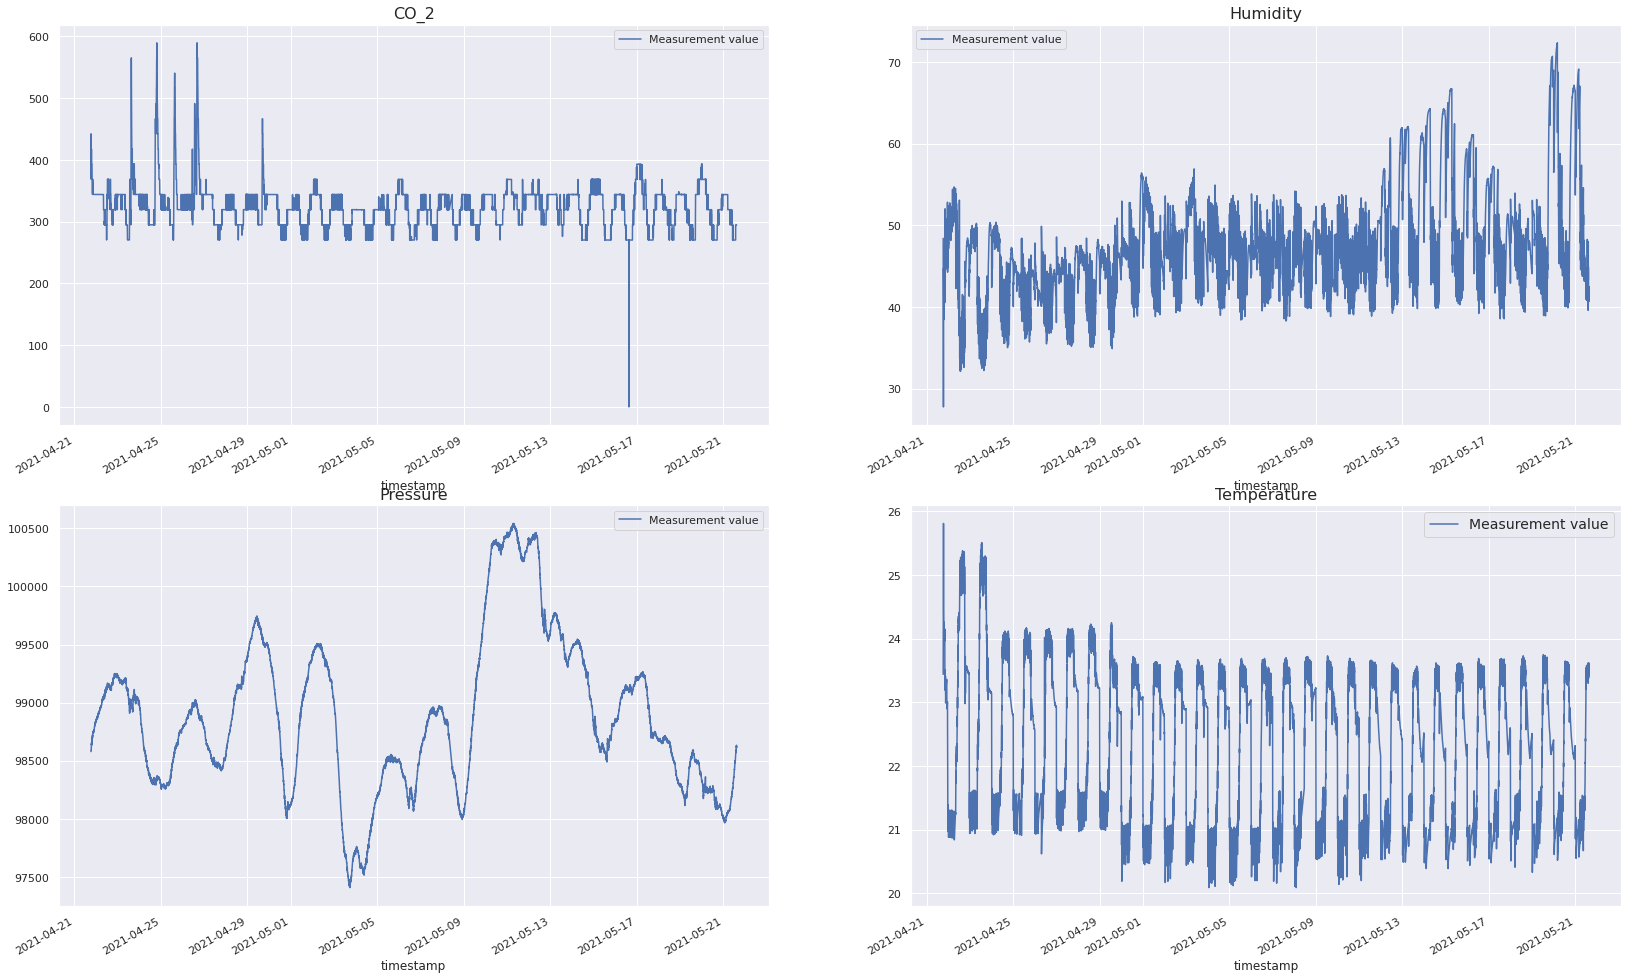

In [286]:
sns.set(rc={'figure.figsize':(28,18)})

f, axes = plt.subplots(2, 2)

data_CO2.plot(ax=axes[0, 0])
axes[0, 0].set_title(f'CO_2', fontsize = 16)

data_HUM.plot(ax=axes[0, 1])
axes[0, 1].set_title('Humidity', fontsize = 16)

data_PRES.plot(ax=axes[1, 0])
axes[1, 0].set_title('Pressure', fontsize = 16)

data_TC.plot(ax=axes[1, 1])
axes[1, 1].set_title(f'Temperature', fontsize = 16)

plt.legend(loc = 'best', fontsize = 14)
plt.show()

In [287]:
#data_Histogram_tmp = data_Histogram_tmp.reset_index()
data_Histogram_tmp = data_Histogram_tmp[data_Histogram_tmp.index <= pd.to_datetime('2021-05-21 15:02:55	')]
data_Histogram_tmp = data_Histogram_tmp[data_Histogram_tmp.index >= pd.to_datetime('2021-04-21 18:21:51	')]
#data_Histogram_tmp.set_index('timestamp', inplace = True)

#data_Histogram_hum = data_Histogram_hum.reset_index()
data_Histogram_hum = data_Histogram_hum[data_Histogram_hum.index <= pd.to_datetime('2021-05-21 15:02:55	')]
data_Histogram_hum = data_Histogram_hum[data_Histogram_hum.index >= pd.to_datetime('2021-04-21 18:21:51	')]
#data_Histogram_hum.set_index('timestamp', inplace = True)


In [288]:
print(f'Datapoints in "raw" dataset: {len(data_HUM)} for given period')
print(f'Datapoints in "precise" dataset: {len(data_Histogram_tmp)} for "raw" dataset period')

Datapoints in "raw" dataset: 10463 for given period
Datapoints in "precise" dataset: 3583 for "raw" dataset period


In [289]:
 data_Histogram_hum[data_Histogram_hum.index <= pd.to_datetime('2021-05-04 15:02:55	')]

,H_real,H_set
Time,,
2021-04-21 18:30:00,45.9,50
2021-04-21 18:42:00,45.1,50
2021-04-21 18:54:00,46.9,50
2021-04-21 19:06:00,44.9,50
2021-04-21 19:18:00,46.3,50
...,...,...
2021-05-04 14:06:00,50.4,50
2021-05-04 14:18:00,50.8,50
2021-05-04 14:30:00,51.1,50


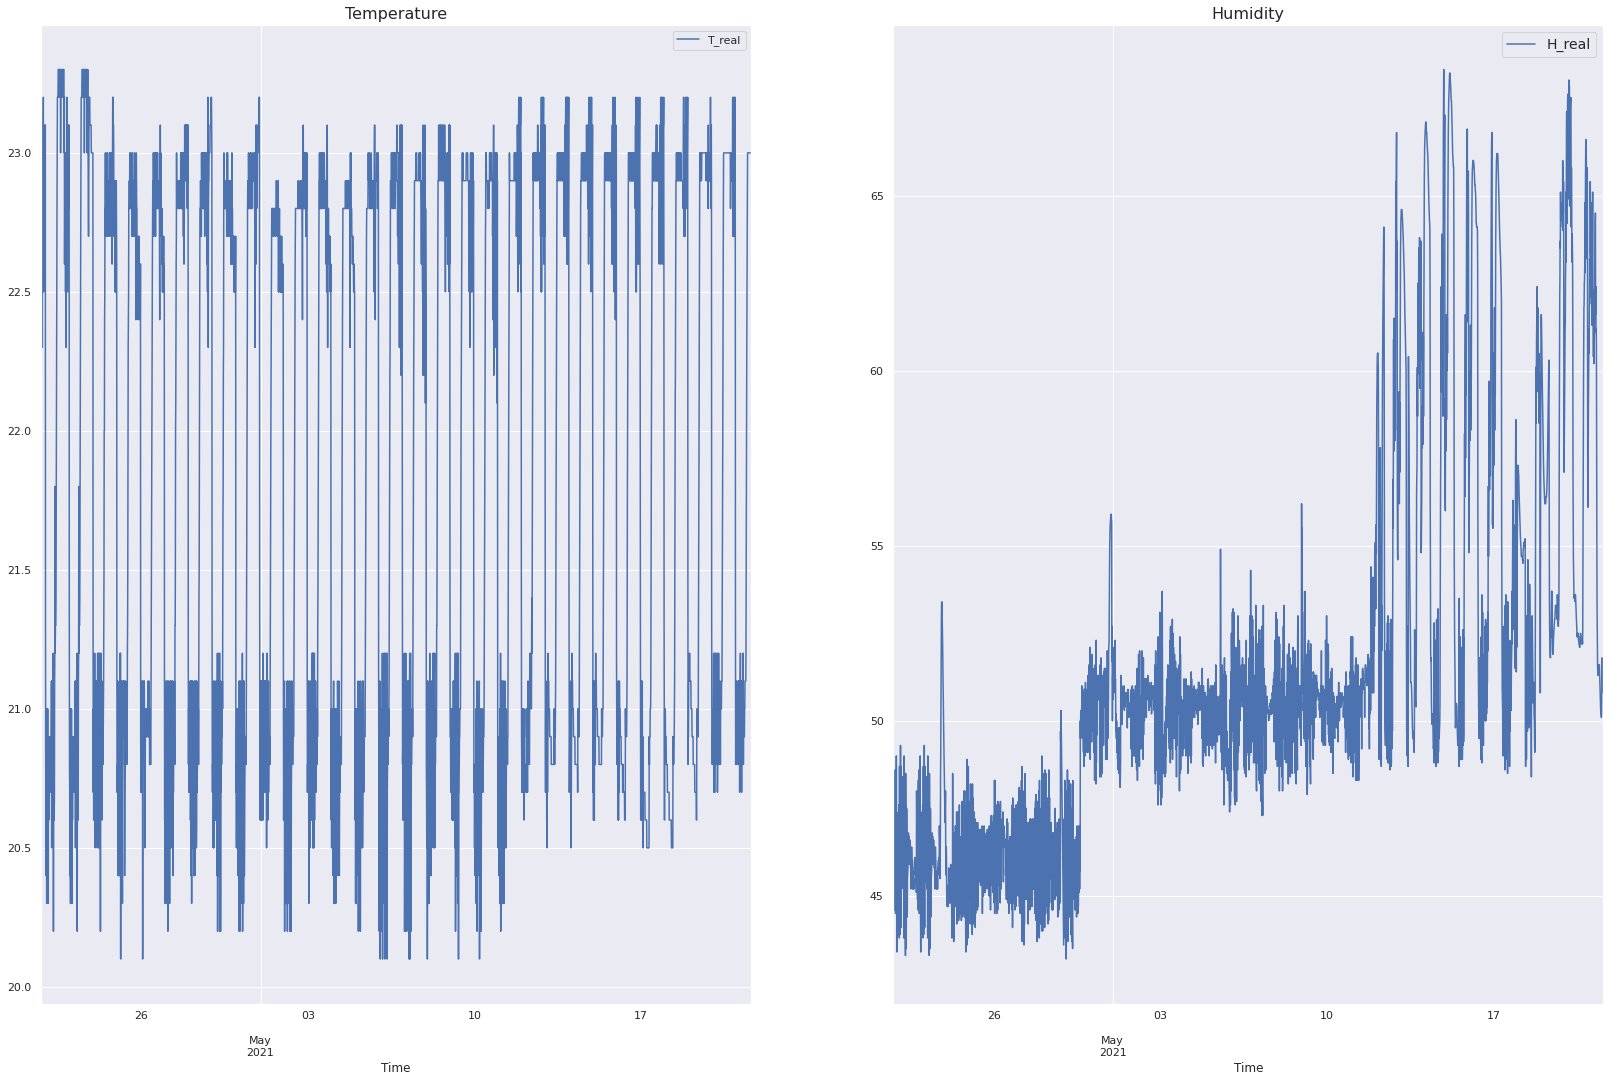

In [290]:
f, (ax1, ax2) = plt.subplots(1, 2)

data_Histogram_tmp.plot(y = 'T_real', ax=ax1)
ax1.set_title(f'Temperature', fontsize = 16)

data_Histogram_hum.plot(y = 'H_real', ax=ax2)
ax2.set_title('Humidity', fontsize = 16)

plt.legend(loc = 'best', fontsize = 14)
plt.show()

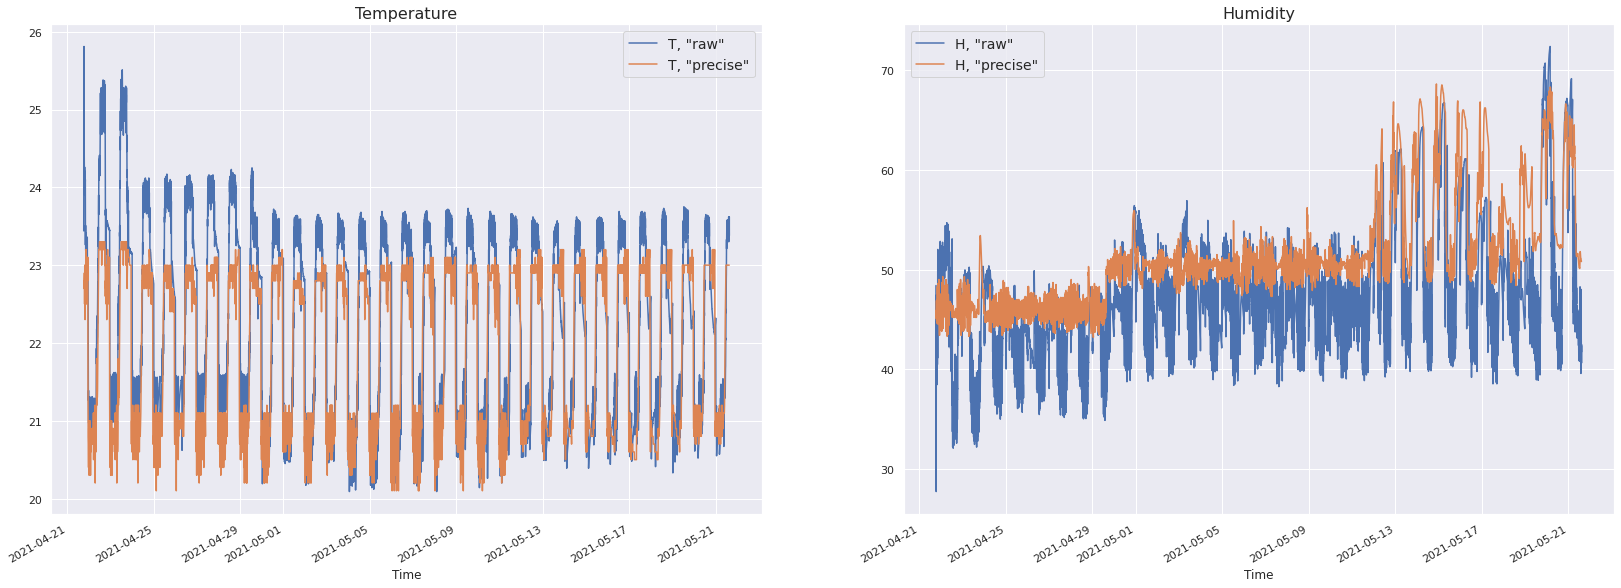

In [291]:
sns.set(rc={'figure.figsize':(28,10)})

f, (ax1, ax2) = plt.subplots(1, 2)

data_TC.plot(ax=ax1)
data_Histogram_tmp.plot(y = 'T_real', ax=ax1)
ax1.set_title(f'Temperature', fontsize = 16)
ax1.legend(['T, "raw"', 'T, "precise"'], loc = 'best', fontsize = 14)

data_HUM.plot(ax=ax2)
data_Histogram_hum.plot(y = 'H_real', ax=ax2)
ax2.set_title('Humidity', fontsize = 16)
ax2.legend(['H, "raw"', 'H, "precise"'], loc = 'best', fontsize = 14)

#plt.legend(loc = 'best', fontsize = 14)
plt.show()

## **1**) Mean and Std in the rolling window

In [292]:
def get_rolling_statistics(df_in, column, window):
    rolling_stats = df_in[column].rolling(window).agg(['mean', 'std'])
    df_out = df_in.join(rolling_stats)
    return df_out

sns.set(rc={'figure.figsize':(18,10)})


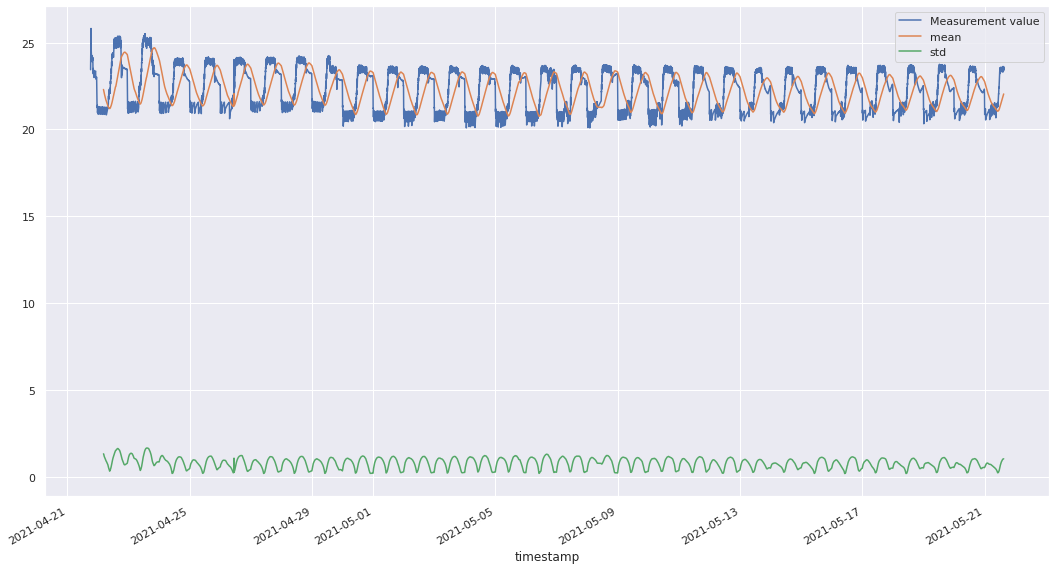

In [293]:
# mean & std temperature

window = 150 

data_tmp_stats = get_rolling_statistics(data_TC, 'Measurement value', window)
data_tmp_stats[['Measurement value', 'mean', 'std']].plot(subplots=False)

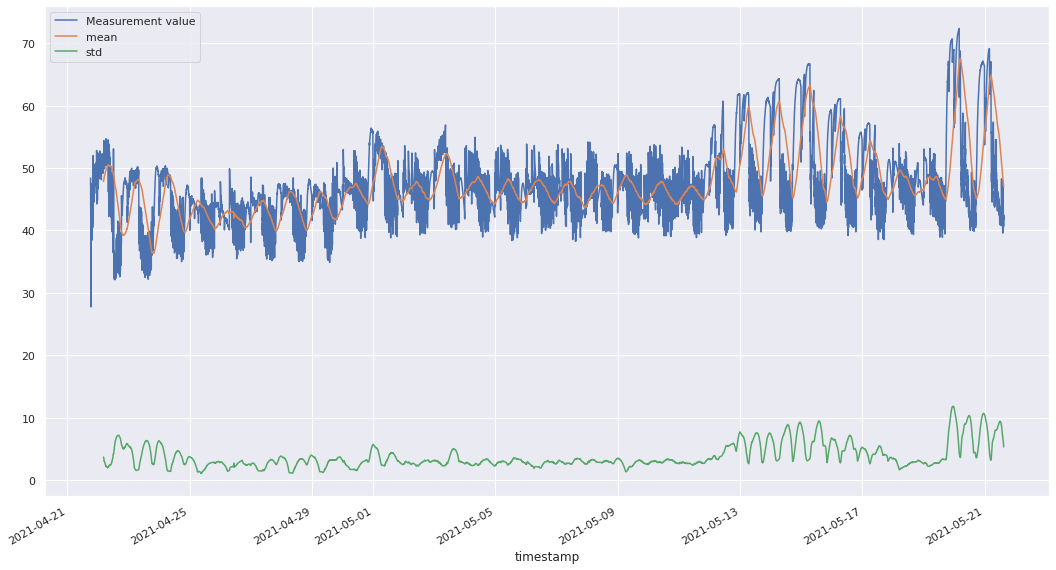

In [294]:
# mean & std humidity

sns.set(rc={'figure.figsize':(18,10)})
window = 150 

data_hum_stats = get_rolling_statistics(data_HUM, 'Measurement value', window)
data_hum_stats[['Measurement value', 'mean', 'std']].plot(subplots=False)

## **2**) Smoothing

Datapoints in original temperature dataset: 10463
Datapoints in Hour-smoothed temperature dataset: 359


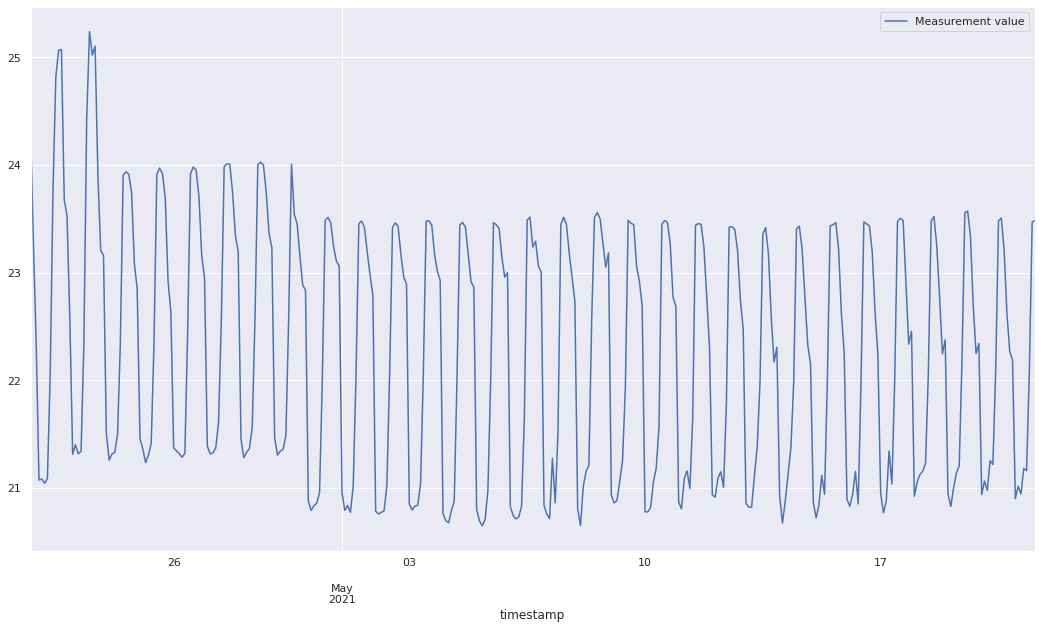

In [295]:
# smoothing temperature within 2 hours
data_TC_hour = data_TC.resample("2H").mean()
data_TC_hour.plot()

print(f'Datapoints in original temperature dataset: {len(data_TC)}')
print(f'Datapoints in Hour-smoothed temperature dataset: {len(data_TC_hour)}')

Datapoints in original humidity dataset: 10463
Datapoints in Hour-smoothed humidity dataset: 359


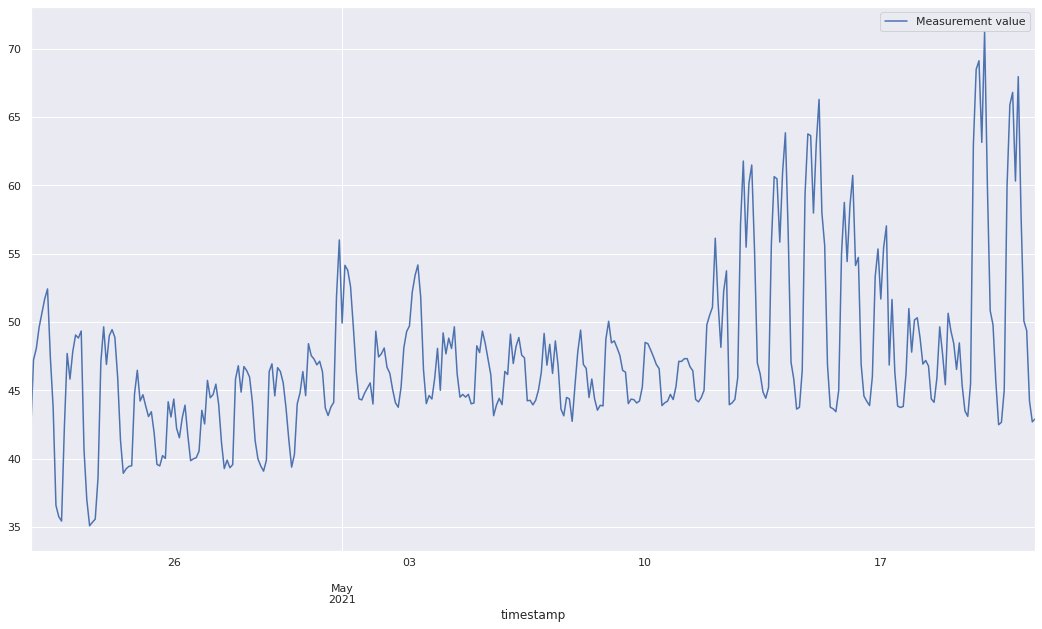

In [296]:
# smoothing humidity within 2 hours  

data_HUM_hour = data_HUM.resample("2H").mean()
data_HUM_hour.plot()

print(f'Datapoints in original humidity dataset: {len(data_HUM)}')
print(f'Datapoints in Hour-smoothed humidity dataset: {len(data_HUM_hour)}')

## 3) ACF & PACF

In [297]:
sns.set(rc={'figure.figsize':(16,9)})

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


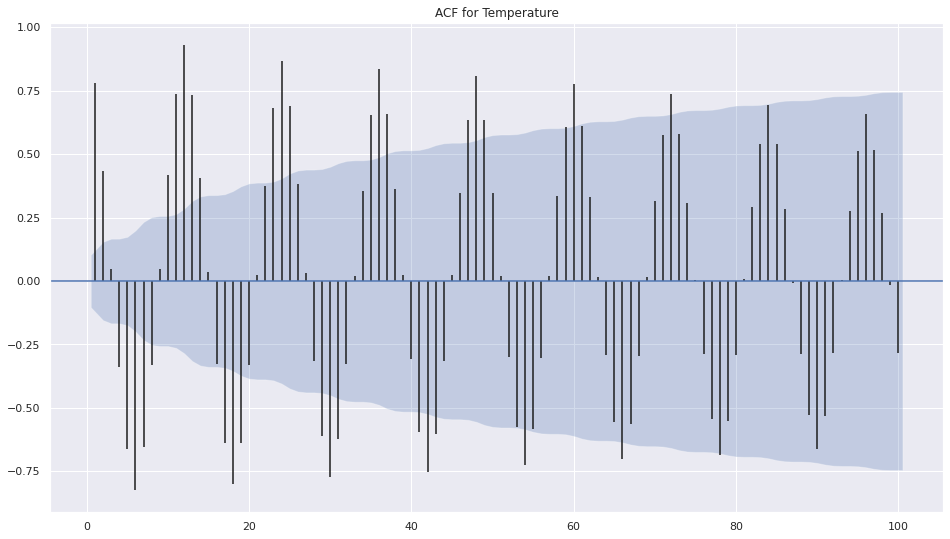

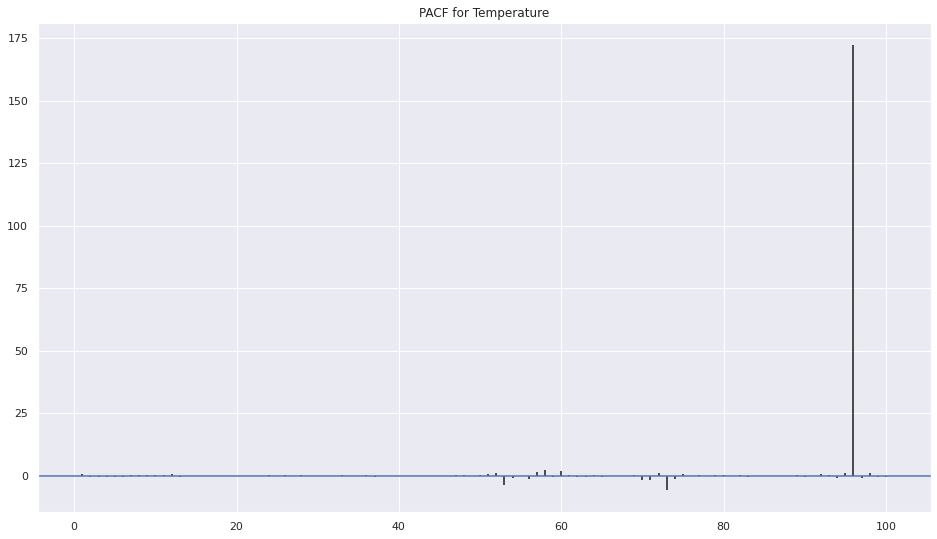

In [298]:
# temperature
lags = 100

tmp_acf = plot_acf(data_TC_hour.values.squeeze(), 
                   lags=lags, 
                   zero=False, 
                   alpha=0.05, 
                   title="ACF for Temperature", 
                   marker=None)

tmp_pacf = plot_pacf(data_TC_hour.values.squeeze(), 
                     lags=lags, 
                     zero=False, 
                     alpha=0.05, 
                     title="PACF for Temperature", 
                     marker=None)

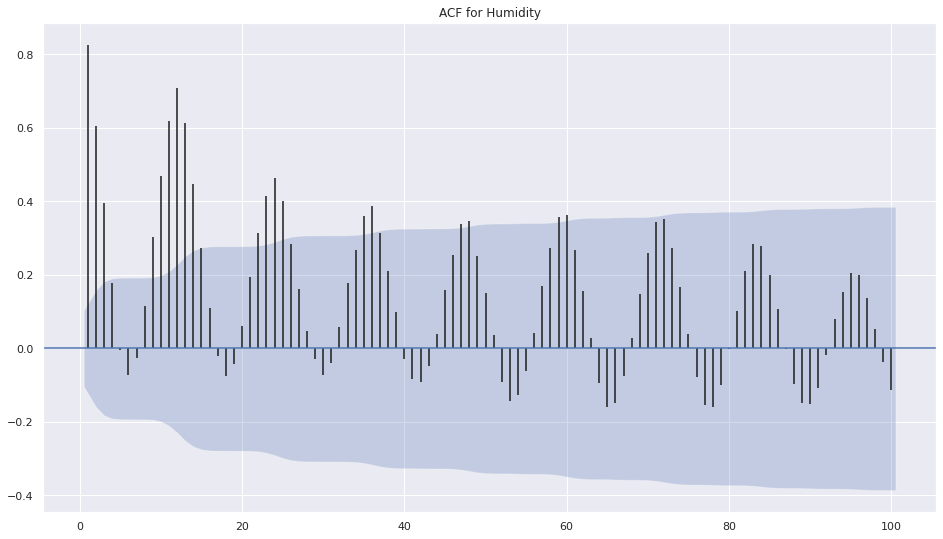

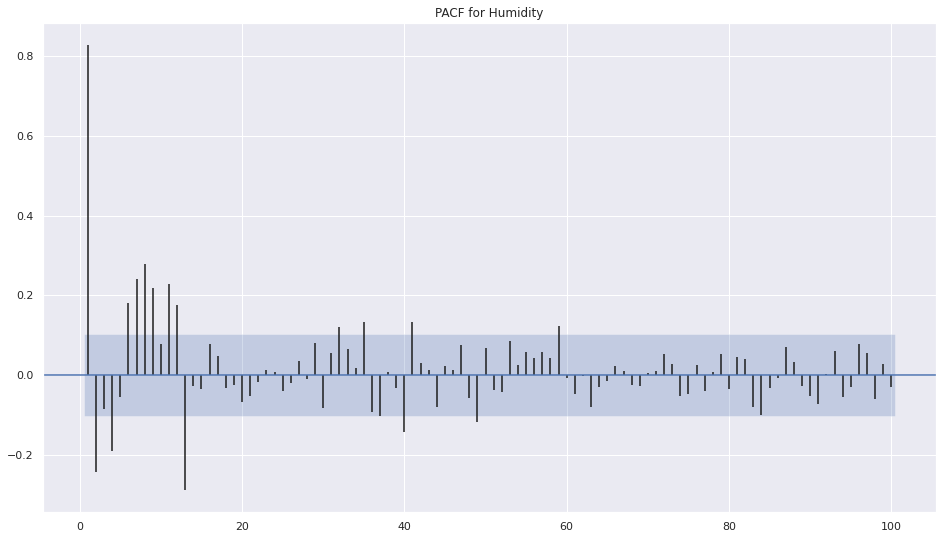

In [299]:
# humidity

lags = 100

hum_acf = plot_acf(data_HUM_hour.values.squeeze(), 
                   lags=lags, 
                   zero=False, 
                   alpha=0.05, 
                   title="ACF for Humidity", 
                   marker=None)

hum_pacf = plot_pacf(data_HUM_hour.values.squeeze(), 
                     lags=lags, 
                     zero=False, 
                     alpha=0.05, 
                     title="PACF for Humidity", 
                     marker=None)

## **4**) Seasonality period

In [300]:
def monthly_seasonality_diagnostics(series, fraction=0.66, period="month"):
    

    trend = sm.api.nonparametric.lowess(series, 
                                        np.r_[:len(series)],
                                        frac=fraction, 
                                        it=5)

    by = getattr(series.index, period, "month")
    season_groupby = (series - trend[:, 1]).groupby(by)
    seas_mean, seas_std = season_groupby.mean(), season_groupby.std()

    fig = plt.figure(figsize=(12, 6))
    ax_top = fig.add_subplot(211, title="Trend")
    ax_bottom = fig.add_subplot(212, title="Seasonality", xlabel=period)

    pd.Series(trend[:, 1], index=series.index).plot(ax=ax_top)
    series.plot(ax=ax_top, color="black", lw=2, alpha=.25, zorder=-10)
    ax_top.grid(which="major", axis="both")

    ax_bottom.plot(1 + np.r_[:len(seas_mean)], seas_mean, lw=2)
    ax_bottom.fill_between(1 + np.r_[:len(seas_mean)],
                           seas_mean - 1.96 * seas_std,
                           seas_mean + 1.96 * seas_std,
                           zorder=-10, color="C1", alpha=0.15)
    ax_bottom.grid(which="major", axis="both")


    fig.tight_layout()
    return fig, seas_mean, trend

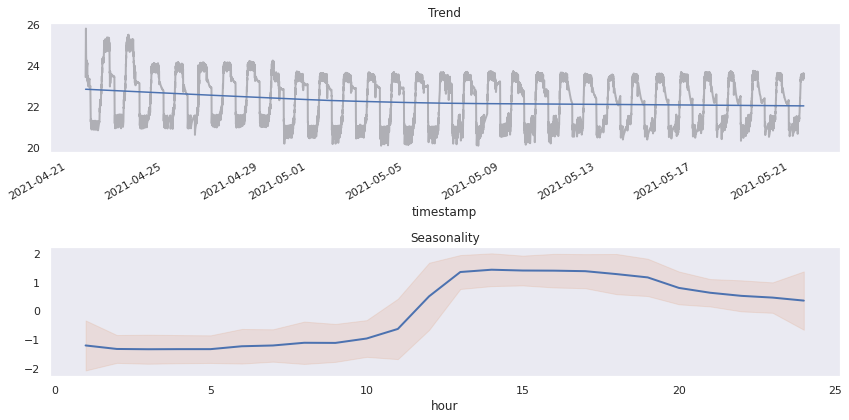

In [301]:
# seasonality temperature
_, seas_mean, trend = monthly_seasonality_diagnostics(data_TC['Measurement value'], period = 'hour')

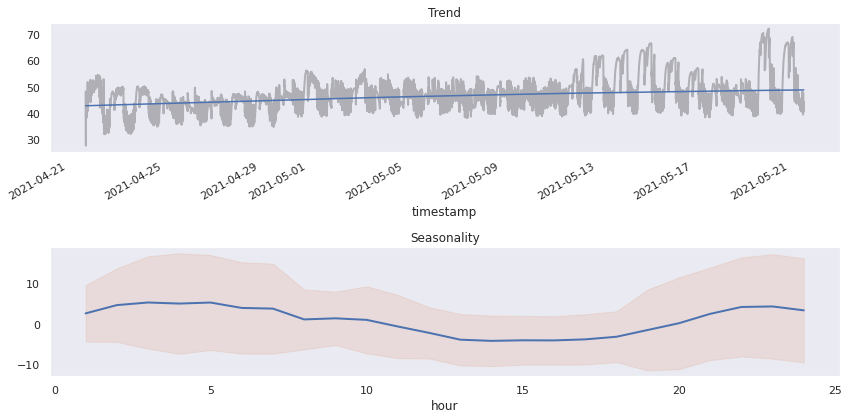

In [302]:
# seasonality humidity 
_, seas_mean, trend = monthly_seasonality_diagnostics(data_HUM['Measurement value'], period = 'hour')

# Data Preprocessing


## **1)** Normalization 

In [303]:
transformer = Pipeline([
    #("LogTransform", FunctionTransformer(func=np.log, inverse_func=np.exp),),
    ("Scaling", MinMaxScaler(feature_range=(0, 1)),),
])

def transform_ds(dataset, transformer):
    transformer = transformer.fit(dataset)
    return pd.DataFrame(transformer.transform(dataset), columns=dataset.columns, index=dataset.index), transformer

In [304]:
# temperature
data_TC_scaled, transformer_TC = transform_ds(data_TC_hour, transformer)

data_TC_scaled.head(5)

,Measurement value
timestamp,
2021-04-21 18:00:00,0.806035
2021-04-21 20:00:00,0.575926
2021-04-21 22:00:00,0.370574
2021-04-22 00:00:00,0.092569
2021-04-22 02:00:00,0.094570


In [305]:
# humidity
data_HUM_scaled, transformer_hum = transform_ds(pd.DataFrame(data_HUM_hour), transformer)

data_HUM_scaled.head(5)

,Measurement value
timestamp,
2021-04-21 18:00:00,0.190137
2021-04-21 20:00:00,0.335630
2021-04-21 22:00:00,0.358708
2021-04-22 00:00:00,0.401609
2021-04-22 02:00:00,0.430972


## **2)** Feature engineering via tsfresh and splitting data

In [306]:
# preprocess temperature data

# we need dummy id index, which will be the same for each datastamp
data_TC_scaled_tmp = data_TC_scaled
data_TC_scaled_tmp['ID'] = np.ones(len(data_TC_scaled))

# window size is 6 * 2 = 12 hours
data_TC_scaled_rolled = roll_time_series(data_TC_scaled.reset_index(), 
                                          column_id="ID", 
                                          column_sort = 'timestamp', 
                                          max_timeshift=12, 
                                          min_timeshift=6)

# feature extraction 
X_tmp = extract_features(data_TC_scaled_rolled, 
                         column_id='id', 
                         column_value = 'Measurement value', 
                         impute_function=impute, 
                         show_warnings=False)

X_tmp = X_tmp.set_index(X_tmp.index.map(lambda x: x[1]), drop=True)

y_tmp = data_TC_scaled['Measurement value']
y_tmp = y_tmp[y_tmp.index.isin(X_tmp.index)]

# selection
X_tmp = feature_selection.selection.select_features(X_tmp, y_tmp)
print(f'\nNumber of selected features: {X_tmp.shape[1]}')

# splitting

train_size = int(len(data_TC_scaled) * 0.7)
X_train_tmp = X_tmp[:train_size]
X_test_tmp = X_tmp[train_size:]

y_train_tmp = y_tmp[y_tmp.index.isin(X_train_tmp.index)]
y_test_tmp = y_tmp[y_tmp.index.isin(X_test_tmp.index)]

print(f'\nTrain shape: {X_train_tmp.shape}, Test shape: {X_test_tmp.shape}')
print(f'Train y shape: {y_train_tmp.shape}, Test y shape: {y_test_tmp.shape}')

Feature Extraction: 100%|██████████| 5/5 [00:19<00:00,  3.85s/it]



Number of selected features: 171

Train shape: (251, 171), Test shape: (102, 171)
Train y shape: (251,), Test y shape: (102,)


In [307]:
# preprocess temperature data

# we need dummy id index, which will be the same for each datastamp
data_HUM_scaled_tmp = data_HUM_scaled
data_HUM_scaled_tmp['ID'] = np.ones(len(data_HUM_scaled))

# window size is up to 1/2 year, which seems to be applicable to such data
data_HUM_scaled_rolled = roll_time_series(data_HUM_scaled.reset_index(), 
                                          column_id="ID", 
                                          column_sort = 'timestamp', 
                                          max_timeshift=12, 
                                          min_timeshift=6)

# feature extraction
X_hum = extract_features(data_HUM_scaled_rolled, 
                         column_id='id', 
                         column_value = 'Measurement value', 
                         impute_function=impute, 
                         show_warnings=False)

X_hum = X_hum.set_index(X_hum.index.map(lambda x: x[1]), drop=True)

y_hum = data_HUM_scaled['Measurement value']
y_hum = y_hum[y_hum.index.isin(X_tmp.index)]

# selection
X_hum = feature_selection.selection.select_features(X_hum, y_hum)
print(f'\nNumber of selected features: {X_hum.shape[1]}')

# splitting

train_size = int(len(data_HUM_scaled) * 0.7)
X_train_hum = X_hum[:train_size]
X_test_hum = X_hum[train_size:]

y_train_hum = y_hum[y_hum.index.isin(X_train_hum.index)]
y_test_hum = y_hum[y_hum.index.isin(X_test_hum.index)]

print(f'\nTrain shape: {X_train_hum.shape}, Test shape: {X_test_hum.shape}')
print(f'Train y shape: {y_train_hum.shape}, Test y shape: {y_test_hum.shape}')

Feature Extraction: 100%|██████████| 5/5 [00:19<00:00,  3.92s/it]



Number of selected features: 197

Train shape: (251, 197), Test shape: (102, 197)
Train y shape: (251,), Test y shape: (102,)


## Visualization of train-test split 

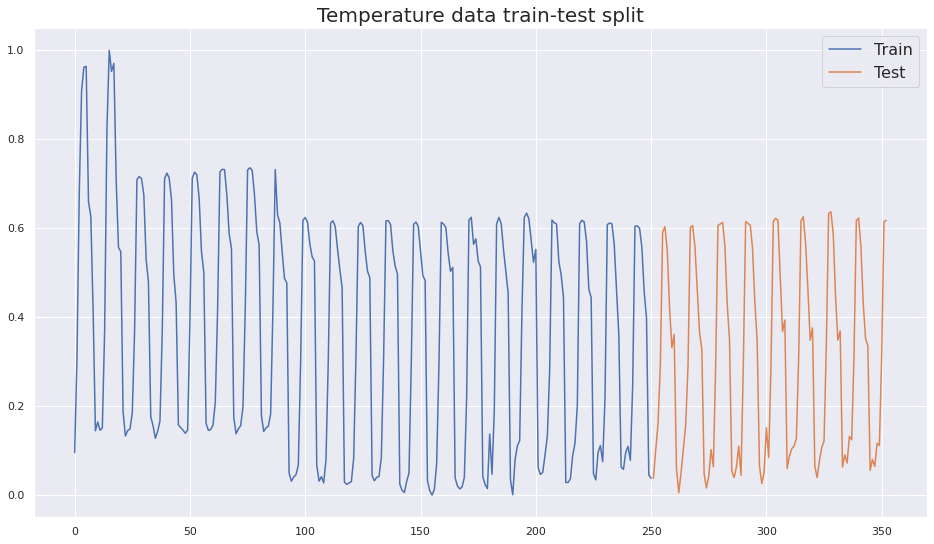

In [308]:
plt.plot(range(0, len(y_train_tmp)), y_train_tmp, label = 'Train')
plt.plot(range(len(y_train_tmp), len(y_train_tmp) + len(y_test_tmp)), y_test_tmp, label = 'Test')

plt.title('Temperature data train-test split', fontsize = 20)
plt.legend(loc = 'best', fontsize = 16)
plt.show()

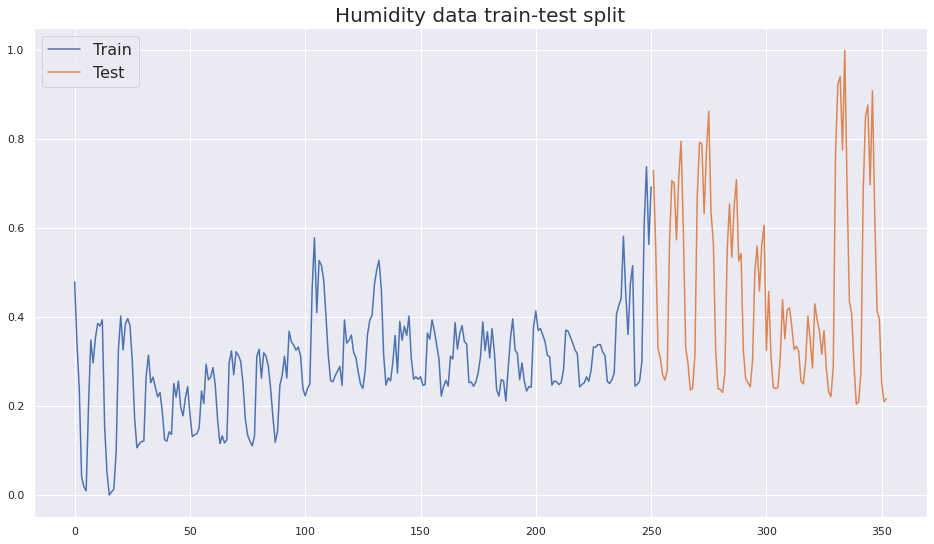

In [309]:
plt.plot(range(0, len(y_train_hum)), y_train_hum, label = 'Train')
plt.plot(range(len(y_train_hum), len(y_train_hum) + len(y_test_hum)), y_test_hum, label = 'Test')

plt.title('Humidity data train-test split', fontsize = 20)
plt.legend(loc = 'best', fontsize = 16)
plt.show()

# Machine Learning

In [310]:
stats_tmp, stats_hum = {}, {}

## Linear Regression

In [311]:
lr = LinearRegression()
lr.fit(X_train_tmp, y_train_tmp)
preds_lr = lr.predict(X_test_tmp)

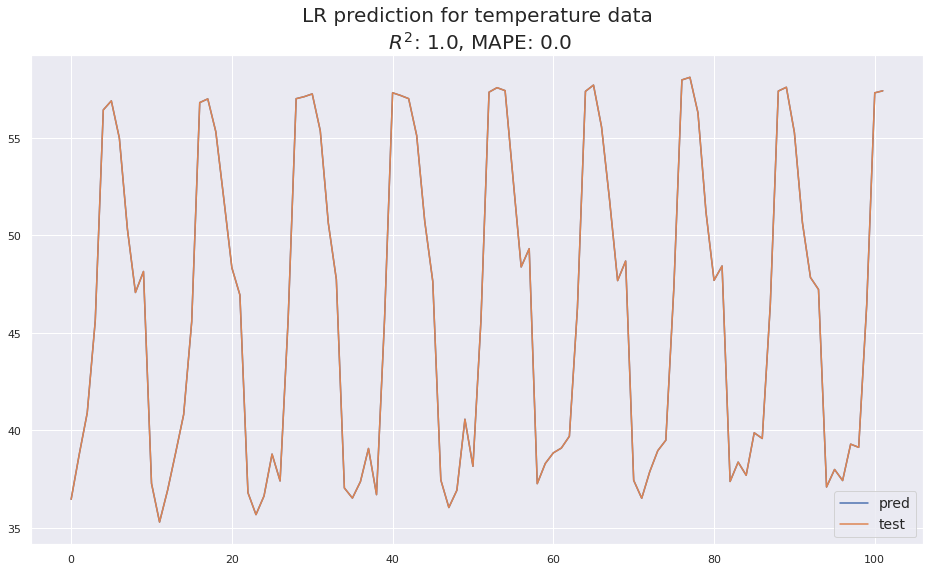

In [312]:
stats_tmp['LR'] = (np.round(r2_score(preds_lr, y_test_tmp), 4), 
                   np.round(mean_absolute_percentage_error(preds_lr, y_test_tmp), 4), 
                   transformer_TC.inverse_transform(preds_lr.reshape(-1, 1)),
                   transformer_TC.inverse_transform(np.array(y_test_tmp.to_list()).reshape(-1, 1)))

plt.plot(stats_tmp['LR'][2], label='pred')
plt.plot(stats_tmp['LR'][3], label='test')
plt.title(f'LR prediction for temperature data\n $R^2$: {stats_tmp["LR"][0]}, MAPE: {stats_tmp["LR"][1]}', fontsize = 20)

plt.legend(loc = 'best', fontsize = 14)
plt.show()

In [313]:
lr = LinearRegression()
lr.fit(X_train_hum, y_train_hum)
preds_lr_hum = lr.predict(X_test_hum)

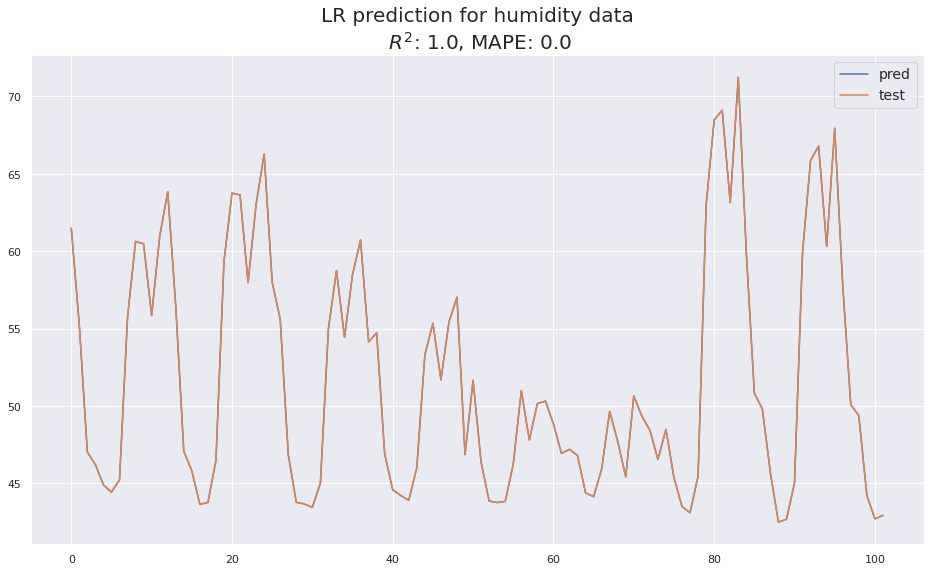

In [314]:
stats_hum['LR'] = (np.round(r2_score(preds_lr_hum, y_test_hum), 4), 
                   np.round(mean_absolute_percentage_error(preds_lr_hum, y_test_hum), 4), 
                   transformer_hum.inverse_transform(preds_lr_hum.reshape(-1, 1)),
                   transformer_hum.inverse_transform(np.array(y_test_hum.to_list()).reshape(-1, 1)))

plt.plot(stats_hum['LR'][2], label='pred')
plt.plot(stats_hum['LR'][3], label='test')
plt.title(f'LR prediction for humidity data\n $R^2$: {stats_hum["LR"][0]}, MAPE: {stats_hum["LR"][1]}', fontsize = 20)

plt.legend(loc = 'best', fontsize = 14)
plt.show()

## Random Forest Regression

In [315]:
rf = RandomForestRegressor()
rf.fit(X_train_tmp, y_train_tmp)
preds_rf = rf.predict(X_test_tmp)

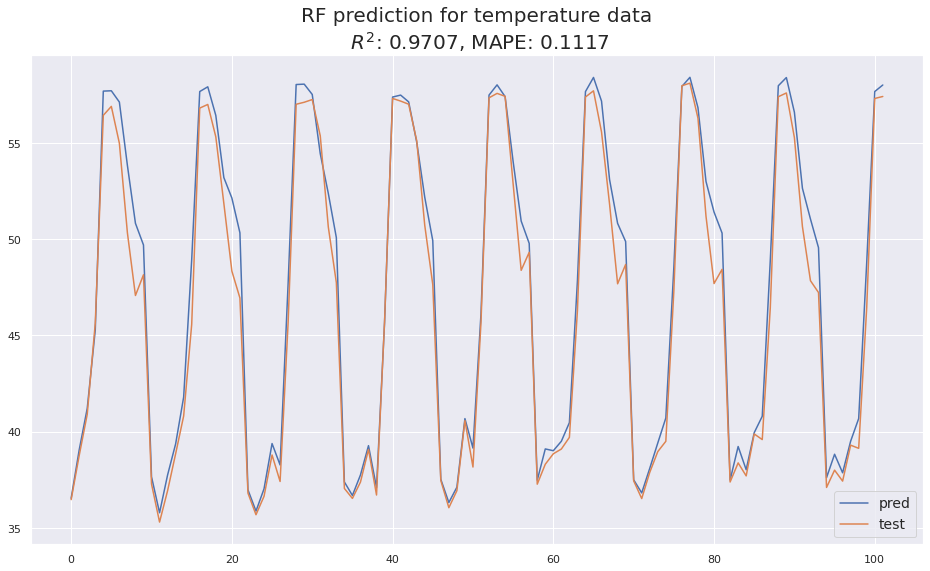

In [316]:
stats_tmp['RF'] = (np.round(r2_score(preds_rf, y_test_tmp), 4), 
                   np.round(mean_absolute_percentage_error(preds_rf, y_test_tmp), 4), 
                   transformer_TC.inverse_transform(preds_rf.reshape(-1, 1)),
                   transformer_TC.inverse_transform(np.array(y_test_tmp.to_list()).reshape(-1, 1)))

plt.plot(stats_tmp['RF'][2], label='pred')
plt.plot(stats_tmp['RF'][3], label='test')
plt.title(f'RF prediction for temperature data\n $R^2$: {stats_tmp["RF"][0]}, MAPE: {stats_tmp["RF"][1]}', fontsize = 20)

plt.legend(loc = 'best', fontsize = 14)
plt.show()

In [317]:
rf = RandomForestRegressor()
rf.fit(X_train_hum, y_train_hum)
preds_rf_hum = rf.predict(X_test_hum)

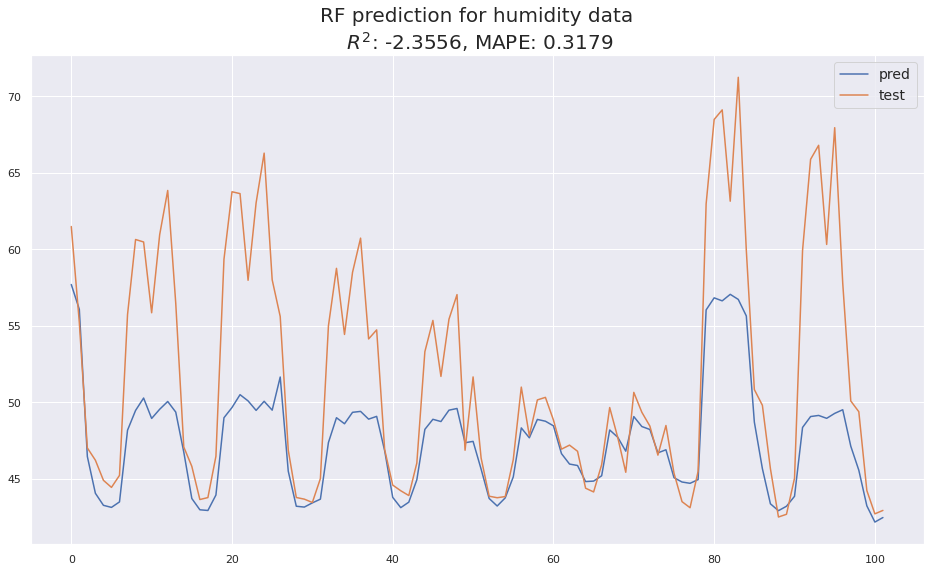

In [318]:
stats_hum['RF'] = (np.round(r2_score(preds_rf_hum, y_test_hum), 4), 
                   np.round(mean_absolute_percentage_error(preds_rf_hum, y_test_hum), 4), 
                   transformer_hum.inverse_transform(preds_rf_hum.reshape(-1, 1)),
                   transformer_hum.inverse_transform(np.array(y_test_hum.to_list()).reshape(-1, 1)))

plt.plot(stats_hum['RF'][2], label='pred')
plt.plot(stats_hum['RF'][3], label='test')
plt.title(f'RF prediction for humidity data\n $R^2$: {stats_hum["RF"][0]}, MAPE: {stats_hum["RF"][1]}', fontsize = 20)

plt.legend(loc = 'best', fontsize = 14)
plt.show()


## LGBM

In [319]:
lgbm = LGBMRegressor()
lgbm.fit(X_train_tmp, y_train_tmp)
preds_lgbm = lgbm.predict(X_test_tmp)

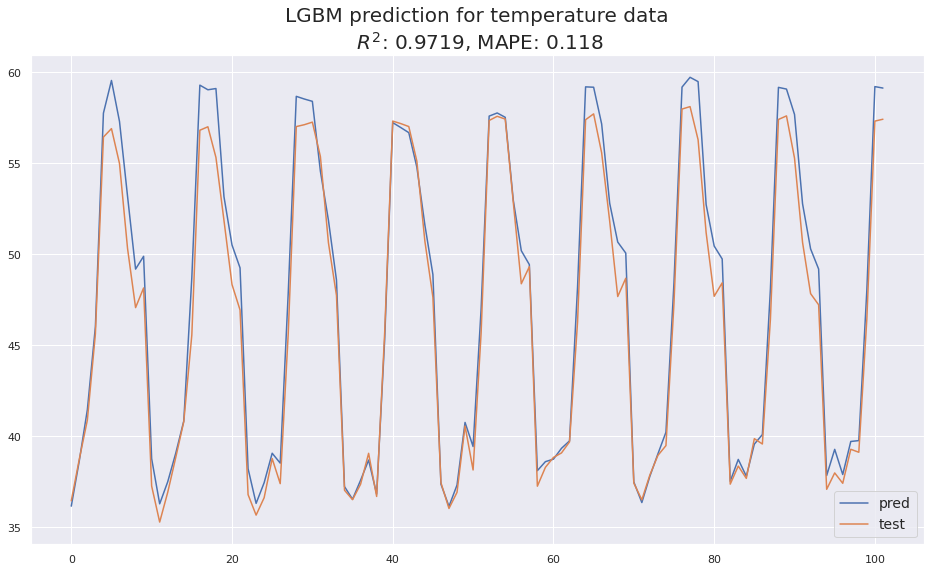

In [320]:
stats_tmp['LGBM'] = (np.round(r2_score(preds_lgbm, y_test_tmp), 4), 
                   np.round(mean_absolute_percentage_error(preds_lgbm, y_test_tmp), 4), 
                   transformer_TC.inverse_transform(preds_lgbm.reshape(-1, 1)),
                   transformer_TC.inverse_transform(np.array(y_test_tmp.to_list()).reshape(-1, 1)))

plt.plot(stats_tmp['LGBM'][2], label='pred')
plt.plot(stats_tmp['LGBM'][3], label='test')
plt.title(f'LGBM prediction for temperature data\n $R^2$: {stats_tmp["LGBM"][0]}, MAPE: {stats_tmp["LGBM"][1]}', fontsize = 20)

plt.legend(loc = 'best', fontsize = 14)
plt.show()


In [321]:
# train for ett dataset
lgbm = LGBMRegressor()
lgbm.fit(X_train_hum, y_train_hum)
preds_lgbm_hum = lgbm.predict(X_test_hum)

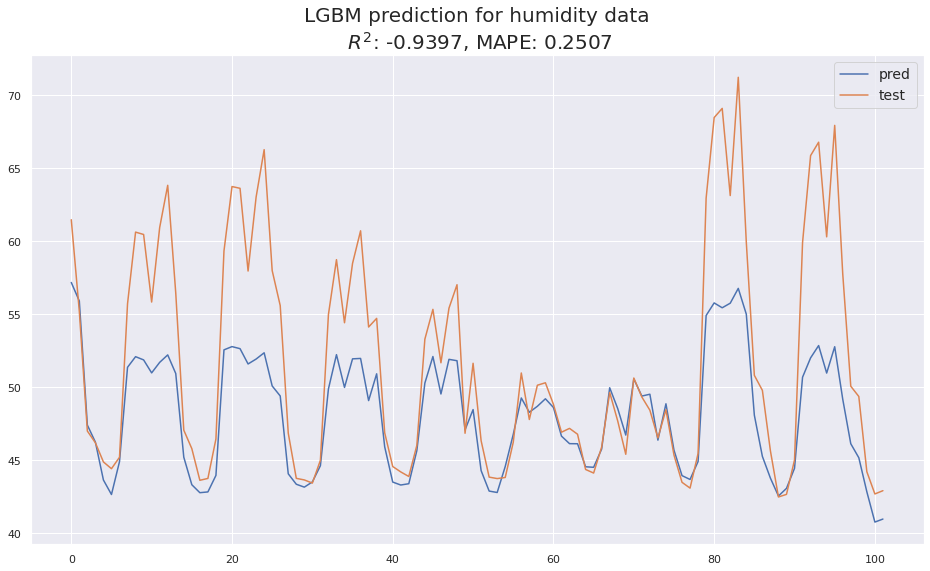

In [322]:
stats_hum['LGBM'] = (np.round(r2_score(preds_lgbm_hum, y_test_hum), 4), 
                   np.round(mean_absolute_percentage_error(preds_lgbm_hum, y_test_hum), 4), 
                   transformer_hum.inverse_transform(preds_lgbm_hum.reshape(-1, 1)),
                   transformer_hum.inverse_transform(np.array(y_test_hum.to_list()).reshape(-1, 1)))

plt.plot(stats_hum['LGBM'][2], label='pred')
plt.plot(stats_hum['LGBM'][3], label='test')
plt.title(f'LGBM prediction for humidity data\n $R^2$: {stats_hum["LGBM"][0]}, MAPE: {stats_hum["LGBM"][1]}', fontsize = 20)

plt.legend(loc = 'best', fontsize = 14)
plt.show()


## ARIMA

In [323]:
!pip install pmdarima
!pip install ruptures
import pmdarima as pm

# Ruptures
import ruptures as rpt 
from ruptures.metrics import precision_recall


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [391]:
# first fit on train to estimate best model parameters for air passengers dataset

arima = pm.auto_arima(y_train_tmp, #start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=6, max_q=6, # maximum p and q
                      m=6,              # frequency of series
                      #d=1,           # let model determine 'd'
                      seasonal=True,   # Yes Seasonality
                      start_P=1, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True,
                      information_criterion='bic')


Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,1,1)[6] intercept   : BIC=-725.972, Time=2.87 sec
 ARIMA(0,0,0)(0,1,0)[6] intercept   : BIC=367.116, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[6] intercept   : BIC=inf, Time=0.90 sec
 ARIMA(0,0,1)(0,1,1)[6] intercept   : BIC=inf, Time=0.92 sec
 ARIMA(0,0,0)(0,1,0)[6]             : BIC=361.669, Time=0.02 sec
 ARIMA(2,0,2)(0,1,1)[6] intercept   : BIC=-192.387, Time=1.84 sec
 ARIMA(2,0,2)(1,1,0)[6] intercept   : BIC=-753.160, Time=2.23 sec
 ARIMA(2,0,2)(0,1,0)[6] intercept   : BIC=-168.032, Time=3.14 sec
 ARIMA(2,0,2)(2,1,0)[6] intercept   : BIC=-726.884, Time=6.21 sec
 ARIMA(2,0,2)(2,1,1)[6] intercept   : BIC=-722.818, Time=6.99 sec
 ARIMA(1,0,2)(1,1,0)[6] intercept   : BIC=-749.229, Time=2.07 sec
 ARIMA(2,0,1)(1,1,0)[6] intercept   : BIC=-753.158, Time=1.21 sec
 ARIMA(3,0,2)(1,1,0)[6] intercept   : BIC=-755.954, Time=2.65 sec
 ARIMA(3,0,2)(0,1,0)[6] intercept   : BIC=inf, Time=1.27 sec
 ARIMA(3,0,2)(2,1,0)[6] intercept   : BIC=-746.635

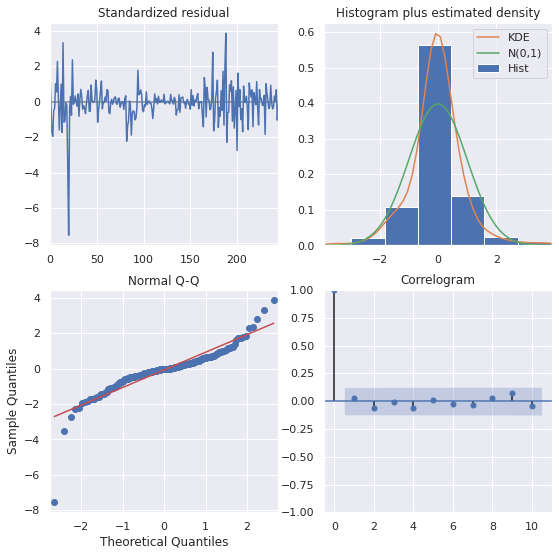

In [392]:
# some arima statistics
arima.plot_diagnostics(figsize=(9,9))
plt.show()

In [393]:
print(arima.summary())

                                 Statespace Model Results                                
Dep. Variable:                                 y   No. Observations:                  251
Model:             SARIMAX(3, 0, 2)x(1, 1, 0, 6)   Log Likelihood                 401.430
Date:                           Wed, 22 Jun 2022   AIC                           -788.860
Time:                                   14:11:16   BIC                           -764.351
Sample:                                        0   HQIC                          -778.990
                                           - 251                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3576      0.126      2.848      0.004       0.111       0.604
ar.L2         -0.5466      0.122     -4.495

In [394]:
preds_arima = arima.predict(n_periods=len(y_test_tmp))
preds_arima_hole_bf= preds_arima[:int(preds_arima.size*0.2)]
preds_arima_hole_af= preds_arima[-int(preds_arima.size*0.2):] 
preds_arima_hole= np.append(preds_arima_hole_bf,preds_arima_hole_af)

In [410]:
y_test_hum
y_test_hum_hole_bf= y_test_hum[:int(y_test_hum.size*0.2)]
y_test_hum_hole_af= y_test_hum[-int(y_test_hum.size*0.2):] 
y_test_hum_hole= np.append(y_test_hum_hole_bf,y_test_hum_hole_af)
y_test_tmp
y_test_tmp_hole_bf= y_test_tmp[:int(y_test_tmp.size*0.2)]
y_test_tmp_hole_af= y_test_tmp[-int(y_test_tmp.size*0.2):] 
y_test_tmp_hole= np.append(y_test_tmp_hole_bf,y_test_tmp_hole_af)

In [411]:
print("prediction:","R2",r2_score(preds_arima, y_test_tmp),"MAPE",mean_absolute_percentage_error(preds_arima, y_test_tmp))
print("hole:","R2",r2_score(preds_arima_hole, y_test_tmp_hole),"MAPE",mean_absolute_percentage_error(preds_arima_hole, y_test_tmp_hole))


prediction: R2 0.9456481061854642 MAPE 0.20699451452430057
hole: R2 0.9326707002365064 MAPE 0.24676006771741904


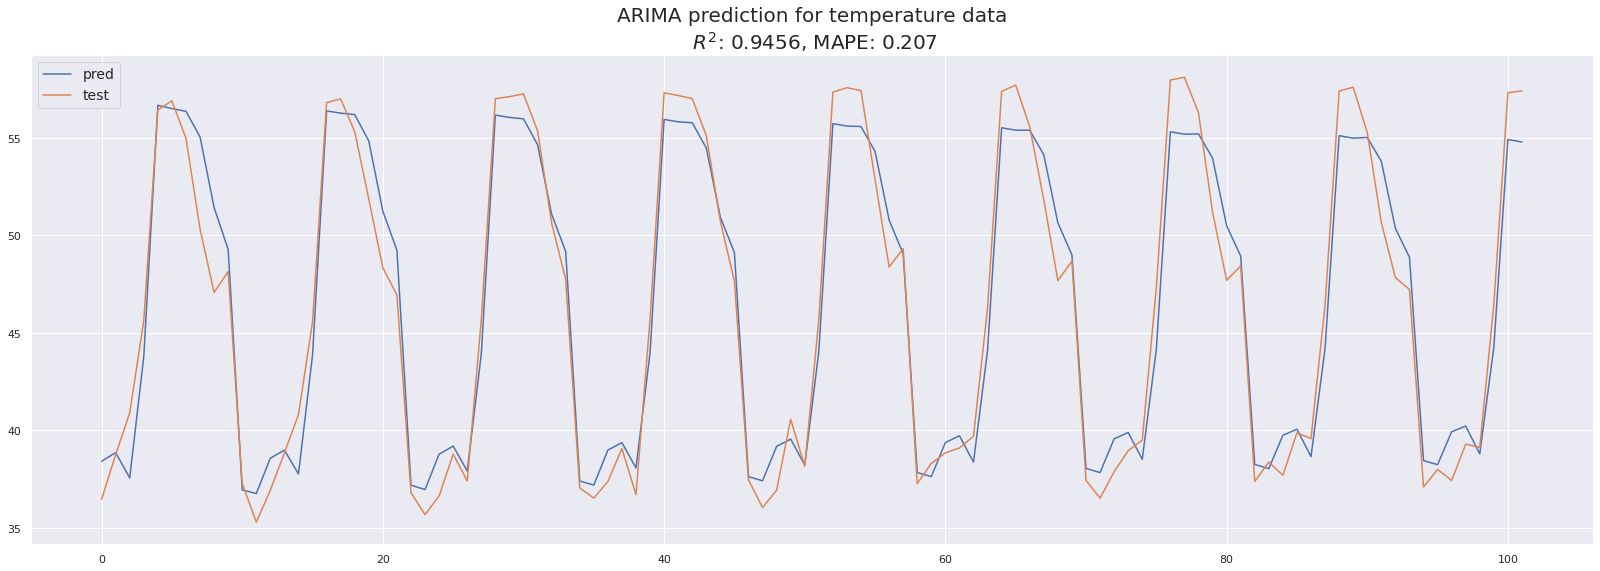

In [406]:
stats_tmp['ARIMA'] = (np.round(r2_score(preds_arima, y_test_tmp), 4), 
                   np.round(mean_absolute_percentage_error(preds_arima, y_test_tmp), 4), 
                   transformer_TC.inverse_transform(preds_arima.reshape(-1, 1)),
                   transformer_TC.inverse_transform(np.array(y_test_tmp.to_list()).reshape(-1, 1)))

plt.plot(stats_tmp['ARIMA'][2], label='pred')
plt.plot(stats_tmp['ARIMA'][3], label='test')
plt.title(f'ARIMA prediction for temperature data\n $R^2$: {stats_tmp["ARIMA"][0]}, MAPE: {stats_tmp["ARIMA"][1]}', fontsize = 20)

plt.legend(loc = 'best', fontsize = 14)
plt.show()

In [329]:
# train for ett dataset
arima = pm.auto_arima(y_train_hum, #start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=4, max_q=4, # maximum p and q
                      m=12,              # frequency of series
                      #d=1,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=1, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True,
                      information_criterion='bic')


Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : BIC=-654.892, Time=10.58 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : BIC=-511.073, Time=0.18 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : BIC=-661.692, Time=3.19 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : BIC=-631.994, Time=3.20 sec
 ARIMA(0,0,0)(0,1,0)[12]             : BIC=-513.027, Time=0.05 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : BIC=-613.695, Time=0.17 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : BIC=-662.899, Time=21.37 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : BIC=inf, Time=16.82 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : BIC=-667.084, Time=3.46 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : BIC=-672.406, Time=2.21 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : BIC=-667.035, Time=5.66 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : BIC=-661.923, Time=5.13 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : BIC=-536.523, Time=0.84 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : BIC=-667.057, Time=2.84 sec
 ARIMA(1,0,1)(0,1,1)[

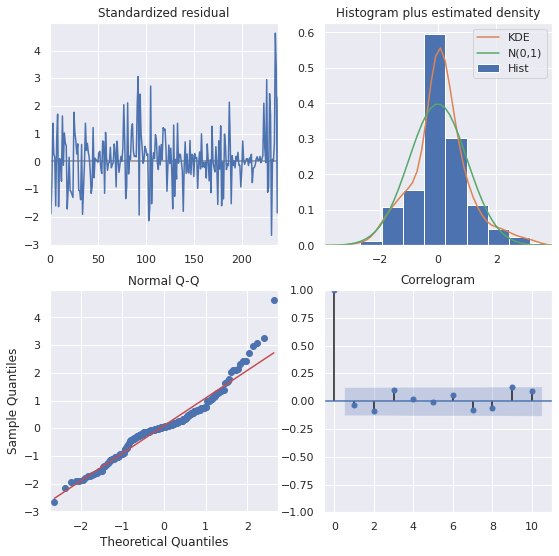

In [330]:
arima.plot_diagnostics(figsize=(9,9))
plt.show()

In [331]:
print(arima.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  251
Model:             SARIMAX(1, 0, 0)x(0, 1, 1, 12)   Log Likelihood                 345.502
Date:                            Wed, 22 Jun 2022   AIC                           -685.004
Time:                                    13:20:24   BIC                           -674.574
Sample:                                         0   HQIC                          -680.801
                                            - 251                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7194      0.030     23.646      0.000       0.660       0.779
ma.S.L12      -0.6438      0.062   

In [413]:
preds_arima_hum = arima.predict(n_periods=len(y_test_hum))
preds_arima_hole_bf= preds_arima_hum[:int(preds_arima_hum.size*0.2)]
preds_arima_hole_af= preds_arima_hum[-int(preds_arima_hum.size*0.2):] 
preds_arima_hole_hum= np.append(preds_arima_hole_bf,preds_arima_hole_af)
print("prediction:","R2",r2_score(preds_arima_hum, y_test_hum),"MAPE",mean_absolute_percentage_error(preds_arima_hum, y_test_hum))
print("hole:","R2",r2_score(preds_arima_hole_hum, y_test_hum_hole),"MAPE",mean_absolute_percentage_error(preds_arima_hole_hum, y_test_hum_hole))


prediction: R2 -0.13396115777492357 MAPE 1.293216407632303
hole: R2 -0.3934268484375918 MAPE 1.4121023418813927


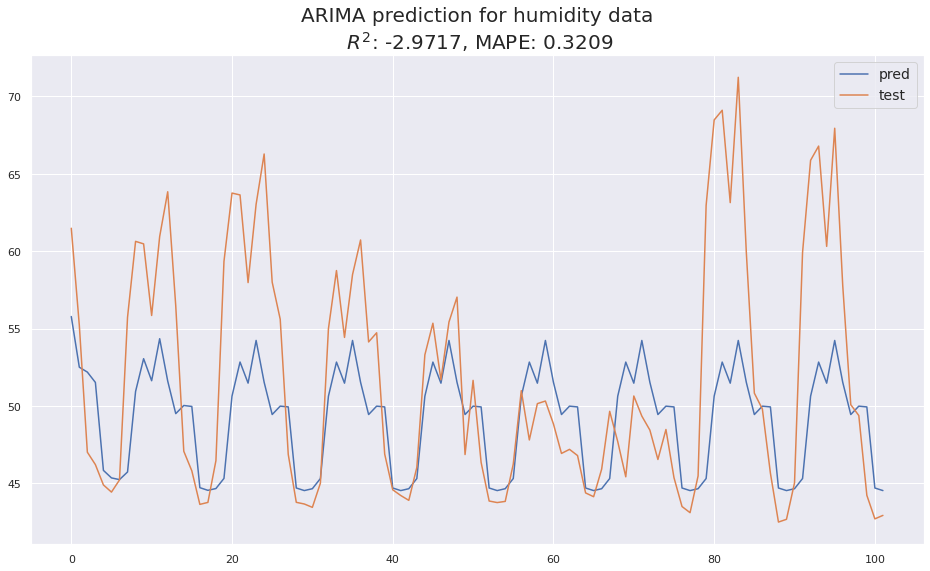

In [333]:
stats_hum['ARIMA'] = (np.round(r2_score(preds_arima_hum, y_test_hum), 4), 
                   np.round(mean_absolute_percentage_error(preds_arima_hum, y_test_hum), 4), 
                   transformer_hum.inverse_transform(preds_arima_hum.reshape(-1, 1)),
                   transformer_hum.inverse_transform(np.array(y_test_hum.to_list()).reshape(-1, 1)))

plt.plot(stats_hum['ARIMA'][2], label='pred')
plt.plot(stats_hum['ARIMA'][3], label='test')
plt.title(f'ARIMA prediction for humidity data\n $R^2$: {stats_hum["ARIMA"][0]}, MAPE: {stats_hum["ARIMA"][1]}', fontsize = 20)

plt.legend(loc = 'best', fontsize = 14)
plt.show()


## Holt-Winters

In [334]:
exp_smoothing = ExponentialSmoothing(y_train_tmp,
                                      trend="add",         # аддитивный тренд
                                      seasonal="add",      # аддитивная сезонность
                                      seasonal_periods=12)

exp_smooth_fitted = exp_smoothing.fit(remove_bias=True)
series_fitted = exp_smooth_fitted.fittedvalues.to_frame()
preds_exp = exp_smooth_fitted.forecast(steps=len(y_test_tmp)).to_frame()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.


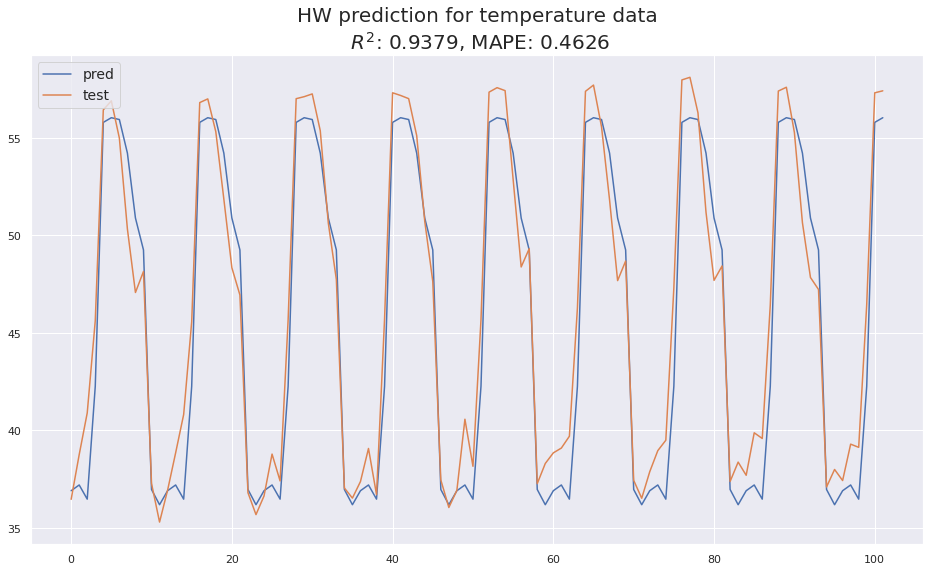

In [335]:
stats_tmp['HW'] = (np.round(r2_score(preds_exp, y_test_tmp), 4), 
                   np.round(mean_absolute_percentage_error(preds_exp, y_test_tmp), 4), 
                   transformer_TC.inverse_transform(preds_exp.values),
                   transformer_TC.inverse_transform(np.array(y_test_tmp.to_list()).reshape(-1, 1)))

plt.plot(stats_tmp['HW'][2], label='pred')
plt.plot(stats_tmp['HW'][3], label='test')
plt.title(f'HW prediction for temperature data\n $R^2$: {stats_tmp["HW"][0]}, MAPE: {stats_tmp["HW"][1]}', fontsize = 20)

plt.legend(loc = 'best', fontsize = 14)
plt.show()


In [336]:
# train for ett dataset
exp_smoothing = ExponentialSmoothing(y_train_hum,
                                      trend="add", 
                                      #damped_trend=True,        # аддитивный тренд
                                      seasonal="add", 
                                      #use_boxcox=True, 
                                      #initialization_method="estimated",    # аддитивная сезонность
                                      seasonal_periods=12)

exp_smooth_fitted = exp_smoothing.fit(remove_bias=True)
series_fitted = exp_smooth_fitted.fittedvalues.to_frame()
preds_exp = exp_smooth_fitted.forecast(steps=len(y_test_hum)).to_frame()

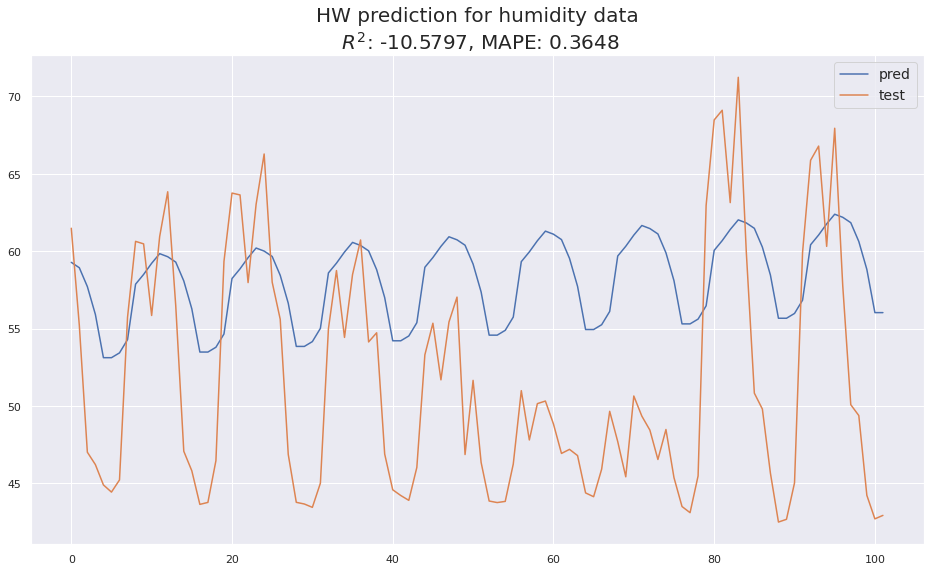

In [337]:

stats_hum['HW'] = (np.round(r2_score(preds_exp, y_test_hum), 4), 
                   np.round(mean_absolute_percentage_error(preds_exp, y_test_hum), 4), 
                   transformer_hum.inverse_transform(preds_exp.values),
                   transformer_hum.inverse_transform(np.array(y_test_hum.to_list()).reshape(-1, 1)))

plt.plot(stats_hum['HW'][2], label='pred')
plt.plot(stats_hum['HW'][3], label='test')
plt.title(f'HW prediction for humidity data\n $R^2$: {stats_hum["HW"][0]}, MAPE: {stats_hum["HW"][1]}', fontsize = 20)

plt.legend(loc = 'best', fontsize = 14)
plt.show()


## LSTM


In [338]:
def create_dataset(dataset, look_back=1):
    '''
    dataset - [N,1] np.ndarray
    look_back - number of points from the past used to predict the next point
    '''
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [339]:
dataset_tmp = y_tmp.values
dataset_tmp = dataset_tmp.astype('float32')
train_size = int(len(dataset_tmp) * 0.6) 
look_back = 20

X_train, y_train = create_dataset(dataset_tmp.reshape(-1, 1)[0:train_size,:], look_back)
X_test, y_test = create_dataset(dataset_tmp.reshape(-1, 1)[train_size:len(dataset_tmp),:], look_back)

# [samples, time step, feature]
X_train = np.reshape(X_train, (*X_train.shape, 1))
X_test = np.reshape(X_test, (*X_test.shape, 1))

print('Temperature:')
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


dataset_hum = y_hum.values
dataset_hum = dataset_hum.astype('float32')
dataset_hum = dataset_hum.reshape(len(dataset_hum), 1)
train_size = int(len(dataset_hum) * 0.6) 
look_back_hum = 20

X_train_hum, y_train_hum = create_dataset(dataset_hum.reshape(-1, 1)[0:train_size,:], look_back_hum)
X_test_hum, y_test_hum = create_dataset(dataset_hum.reshape(-1, 1)[train_size:len(dataset_hum),:], look_back_hum)

# [samples, time step, feature]
X_train_hum = np.reshape(X_train_hum, (*X_train_hum.shape, 1))
X_test_hum = np.reshape(X_test_hum, (*X_test_hum.shape, 1))

print('Humidity:')
print(X_train_hum.shape, y_train_hum.shape)
print(X_test_hum.shape, y_test_hum.shape)

Temperature:
(190, 20, 1) (190,)
(121, 20, 1) (121,)
Humidity:
(190, 20, 1) (190,)
(121, 20, 1) (121,)


In [340]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()

        self.hidden_size = hidden_size

        self.rnn_cell_1 = nn.LSTM(input_size, 
                                  hidden_size, 
                                  batch_first=True,
                                  dropout=0.2) 

        self.rnn_cell_2 = nn.LSTM(hidden_size, 
                                  hidden_size,
                                  dropout=0.2)
        
        self.dense = nn.Linear(hidden_size, 
                               output_size)
    
    def forward(self, x): 
        '''
        x - torch.tensor: [dt,1]
        '''

        h_0 = Variable(torch.zeros(1, self.hidden_size))
        c_0 = Variable(torch.zeros(1, self.hidden_size))

        output, (h_out, c_out) = self.rnn_cell_1(x, (h_0, c_0))
        #output, (h_out, c_out) = self.rnn_cell_2(h_out, (h_out, c_out))

        
        h_out = h_out.view(-1, self.hidden_size)
        out = self.dense(h_out)

        return out#.sigmoid()


In [341]:
# train two models: for airplaine passengers and ett dataset
# train two models: for airplaine passengers and ett dataset
def train(X_train, y_train, hidden_size = 8, N_epochs = 100):
    
    rnn_model = RNNModel(input_size = 1, hidden_size = hidden_size, output_size = 1)
    optimizer = torch.optim.Adam(rnn_model.parameters(), lr=1e-4)
    criterion = torch.nn.MSELoss() 
    loss_history = []

    rnn_model.train()

    for epoch in range(N_epochs):
        loss_epoch = 0
        
        for x,y in zip(X_train, y_train[:,None]):
            
            # iterate over batch
            x_tensor = torch.tensor(x).float()
            y_tensor = torch.tensor(y).float()

            # ВАШ КОД
            pred = rnn_model(x_tensor)
            #loss = torch.norm((pred[-1] - y_tensor)**2.0)
            loss = criterion(pred[-1], y_tensor)
            
            loss_epoch = loss_epoch + loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        

        loss_history.append(loss.item())


        if epoch % 10 == 0:
            print(f'MSE Loss after {epoch} epoch = {loss.item()}, Predicted: {pred[-1].item()}, True: {y_tensor.item()}')

    return rnn_model, loss_history

In [342]:
rnn_model_hum, loss_history_hum = train(X_train_hum, y_train_hum, 32, 70)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


MSE Loss after 0 epoch = 8.672618423588574e-05, Predicted: 0.26445725560188293, True: 0.25514456629753113
MSE Loss after 10 epoch = 0.0020082483533769846, Predicted: 0.2999580502510071, True: 0.25514456629753113
MSE Loss after 20 epoch = 0.0018101776950061321, Predicted: 0.297690749168396, True: 0.25514456629753113
MSE Loss after 30 epoch = 0.001369000063277781, Predicted: 0.2921445667743683, True: 0.25514456629753113
MSE Loss after 40 epoch = 0.0003962363407481462, Predicted: 0.27505025267601013, True: 0.25514456629753113
MSE Loss after 50 epoch = 0.00017576219397597015, Predicted: 0.268402099609375, True: 0.25514456629753113
MSE Loss after 60 epoch = 0.00019966605759691447, Predicted: 0.26927489042282104, True: 0.25514456629753113


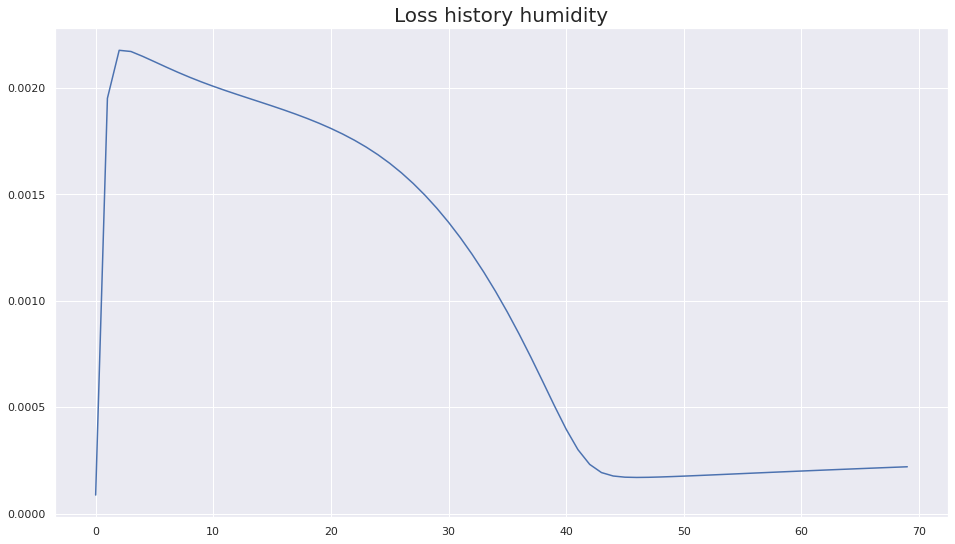

In [343]:
plt.plot(loss_history_hum)

plt.title('Loss history humidity', fontsize = 20)

plt.show()

In [344]:
def get_prediction(rnn_model, X_train, X_test):

    rnn_model.eval()

    preds_rnn_test = []
    for x_i in X_test:
        x_i = torch.tensor(x_i).float()
        pred = rnn_model(x_i)
        preds_rnn_test.append(pred.detach().numpy()[0])

    preds_rnn_test = np.array(preds_rnn_test)

    preds_rnn_train = []
    for x_i in X_train:
        x_i = torch.tensor(x_i).float()
        pred = rnn_model(x_i)
        preds_rnn_train.append(pred.detach().numpy()[0])
    preds_rnn_train = np.array(preds_rnn_train)

    return preds_rnn_train, preds_rnn_test

#preds_rnn_train_tmp, preds_rnn_test_tmp = get_prediction(rnn_model_tmp, X_train, X_test)
preds_rnn_train_hum, preds_rnn_test_hum = get_prediction(rnn_model_hum, X_train_hum, X_test_hum)

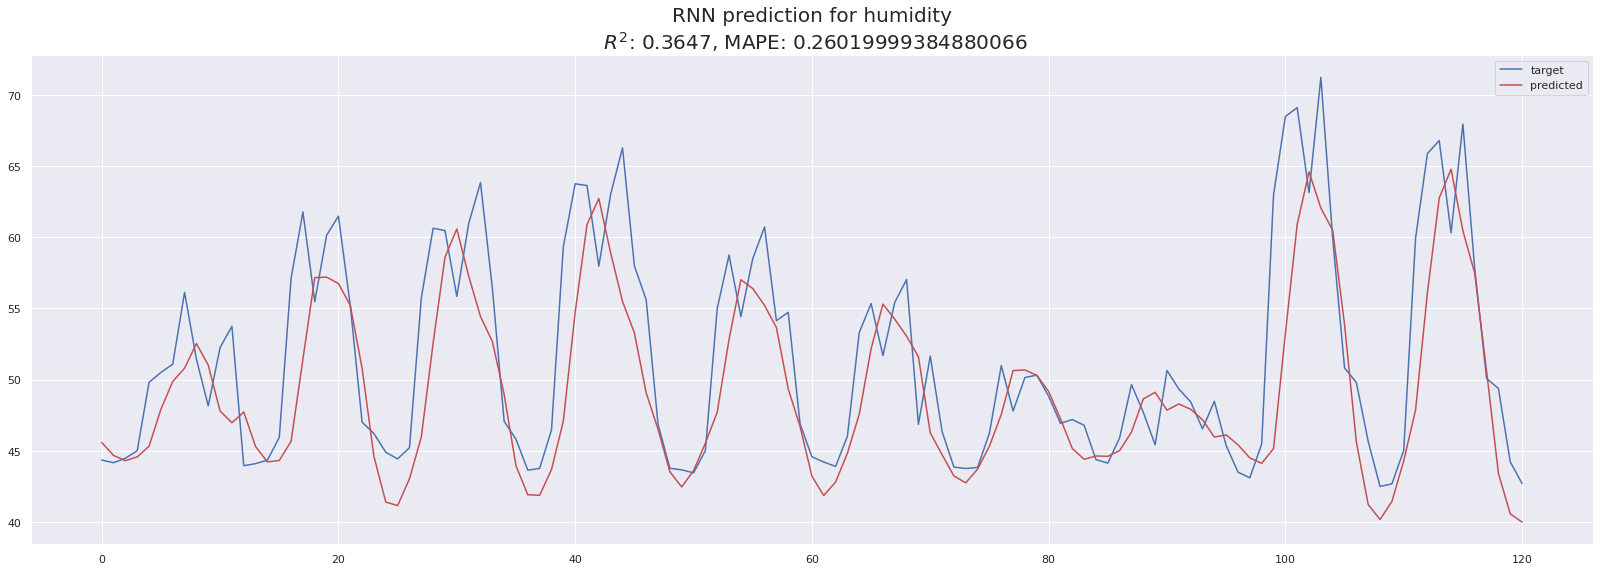

In [414]:
preds_data = (np.round(r2_score(preds_rnn_test_hum, y_test_hum), 4), 
              np.round(mean_absolute_percentage_error(preds_rnn_test_hum, y_test_hum), 4), 
              transformer_TC.inverse_transform(preds_rnn_test_hum),
              transformer_TC.inverse_transform(np.array(y_test_hum).reshape(-1, 1)))

plt.title(f'RNN prediction for humidity\n $R^2$: {preds_data[0]}, MAPE: {preds_data[1]}', fontsize = 20)

plt.plot(transformer.inverse_transform(y_test_hum.reshape(len(y_test_hum), 1)), label='target', c = 'b')
plt.plot(transformer_hum.inverse_transform(preds_rnn_test_hum), label='predicted', c = 'r')

plt.legend()
plt.show()

In [417]:
preds_rnn_test_hum_hole_bf= preds_rnn_test_hum[:int(preds_rnn_test_hum.size*0.2)]
preds_rnn_test_hum_hole_af= preds_rnn_test_hum[-int(preds_rnn_test_hum.size*0.2):] 
preds_rnn_hole_hum= np.append(preds_rnn_test_hum_hole_bf,preds_rnn_test_hum_hole_af)
print("prediction:","R2",r2_score(preds_rnn_test_hum, y_test_hum),"MAPE",mean_absolute_percentage_error(preds_rnn_test_hum, y_test_hum))
print("hole:","R2",r2_score(preds_rnn_hole_hum, y_test_hum_hole),"MAPE",mean_absolute_percentage_error(preds_rnn_hole_hum, y_test_hum_hole))


prediction: R2 0.3646784876870467 MAPE 0.26020396
hole: R2 0.30654653235958385 MAPE 0.31842613


# Comparison of different ML algorithms


In [346]:
sns.set(rc={'figure.figsize':(28,9)})

def plot_for_model(key):
    
    f, (ax1, ax2) = plt.subplots(1, 2)

    ax1.plot(stats_tmp[key][2], label='pred')
    ax1.plot(stats_tmp[key][3], label='test')
    ax2.plot(stats_hum[key][2], label='pred')
    ax2.plot(stats_hum[key][3], label='test')

    ax1.set_title(f'{key} prediction for air dataset\n $R^2$: {stats_tmp[key][0]}, MAPE: {stats_tmp[key][1]}', fontsize = 20)
    ax2.set_title(f'{key} prediction for ett dataset\n $R^2$: {stats_hum[key][0]}, MAPE: {stats_hum[key][1]}', fontsize = 20)

    ax1.legend(loc = 'best', fontsize = 14)
    ax2.legend(loc = 'best', fontsize = 14)

    plt.show()

KeyError: ignored

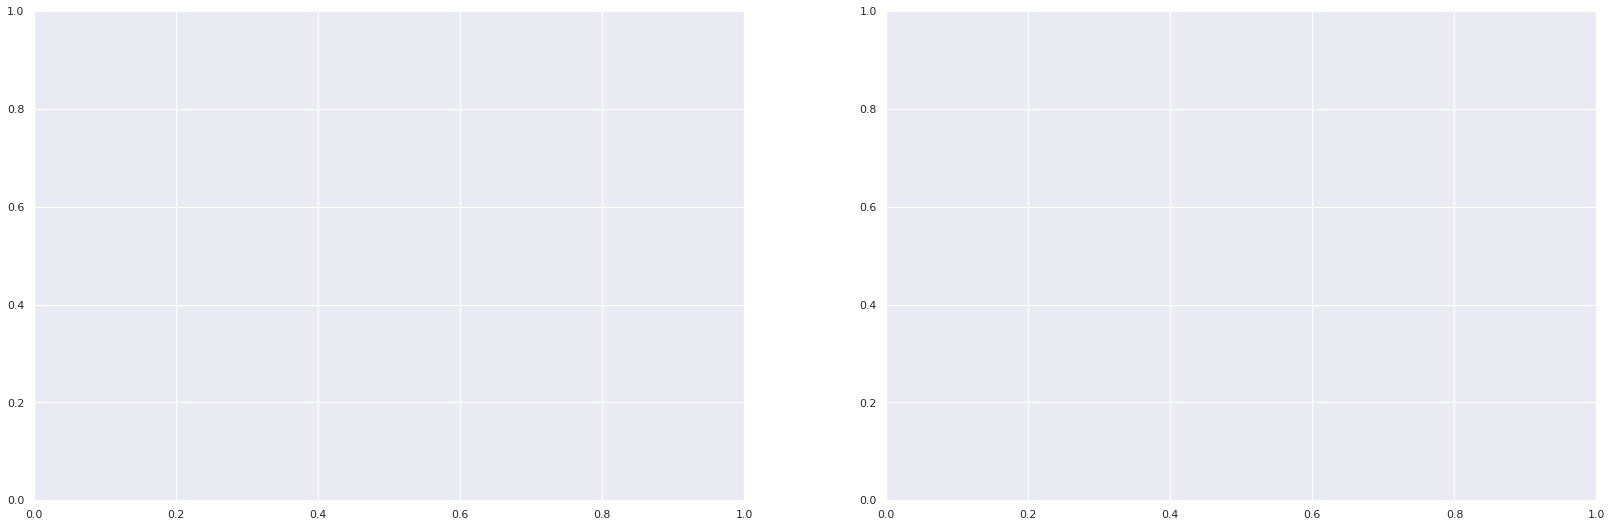

In [48]:
# LR
plot_for_model('LR')

In [ ]:
# RF

plot_for_model('RF')

In [ ]:
# LGBM

plot_for_model('LGBM')

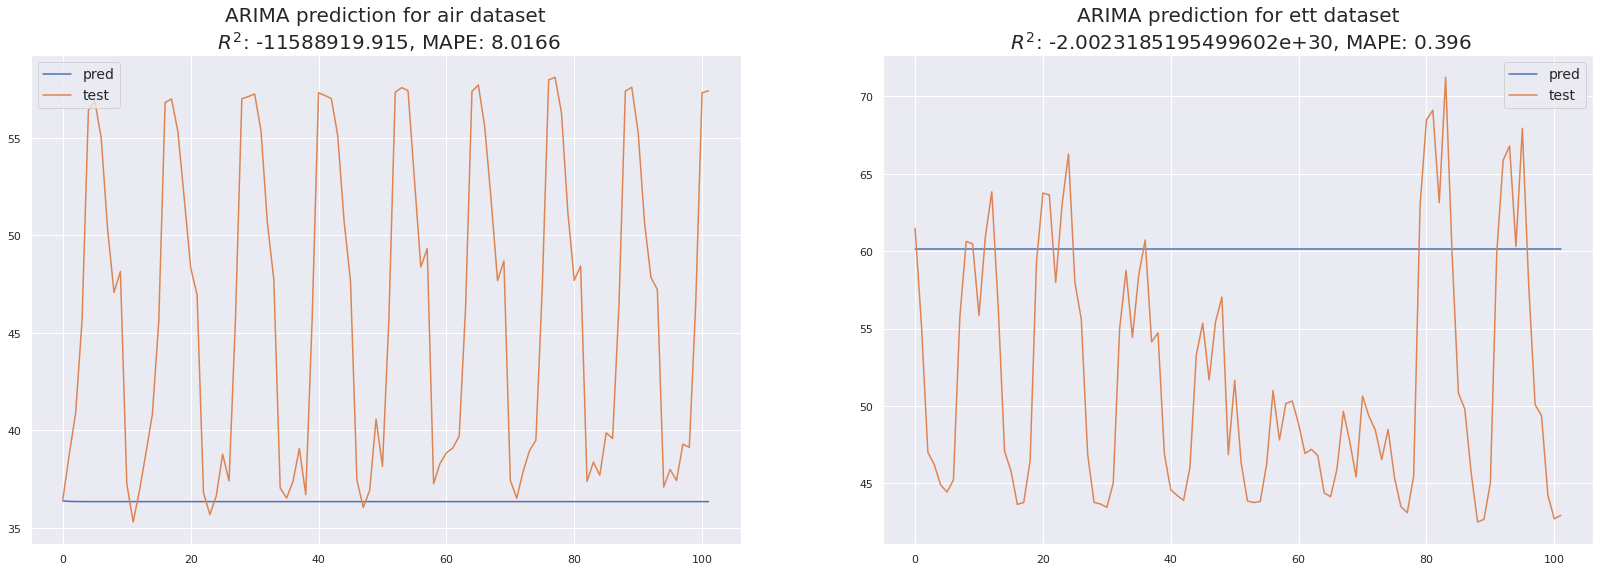

In [ ]:
# ARIMA

plot_for_model('ARIMA')

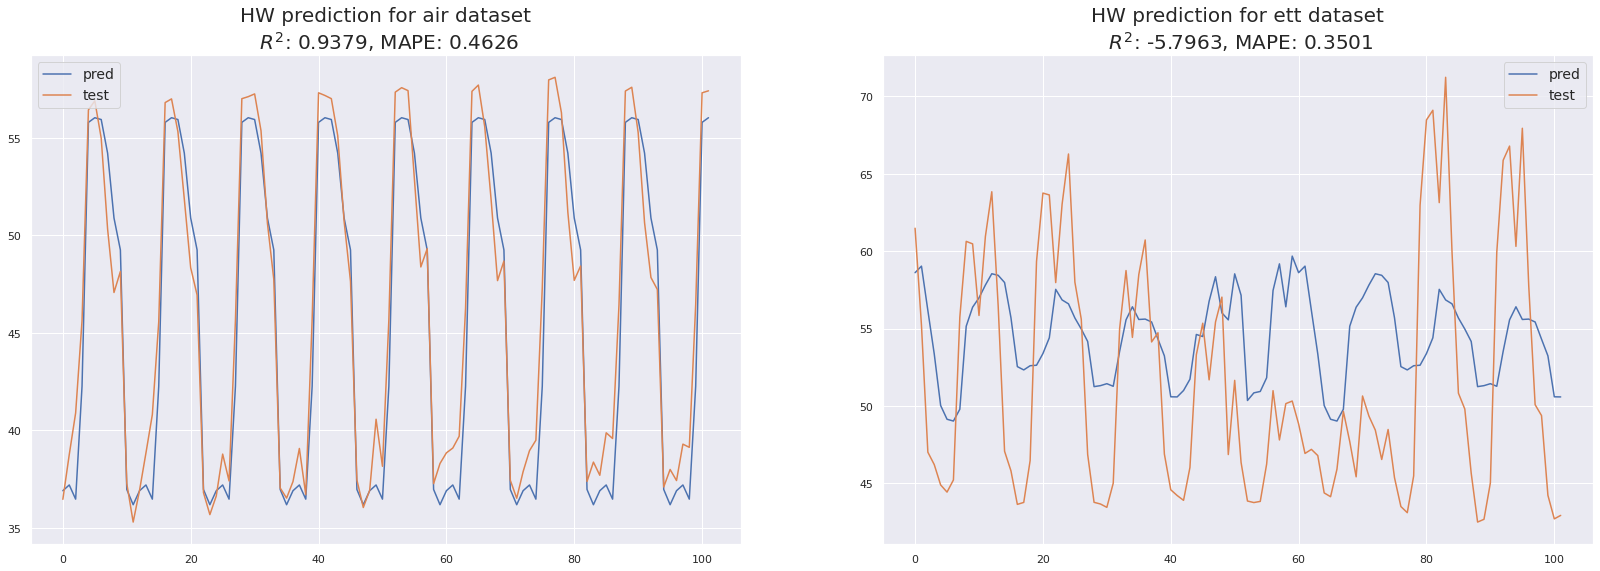

In [ ]:
# Holt-Winters

plot_for_model('HW')

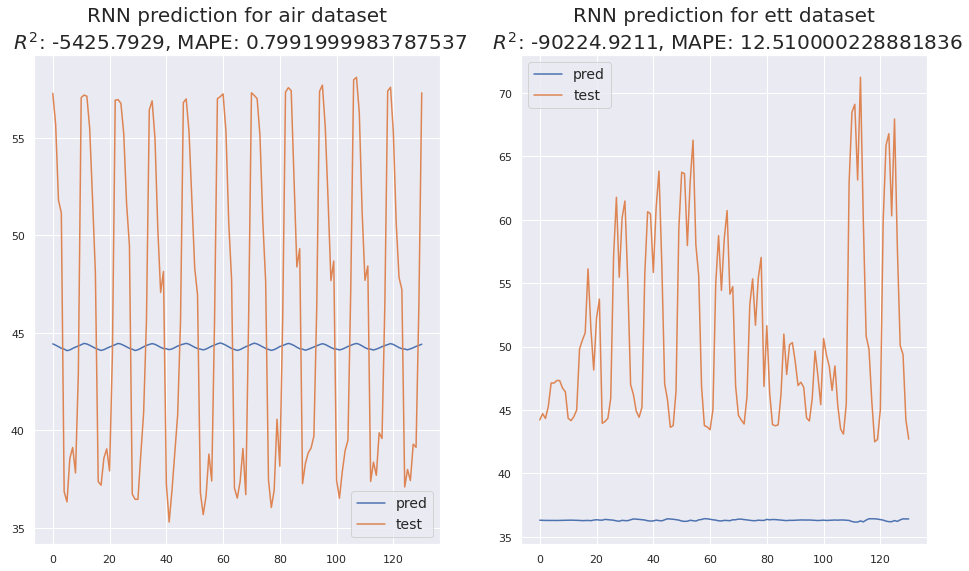

In [ ]:
# RNN (LSTM)

plot_for_model('RNN')

# Change Point Detection

[20, 80, 353]


(<Figure size 720x144 with 1 Axes>,
 [<matplotlib.axes._subplots.AxesSubplot at 0x7f00c415ec90>])

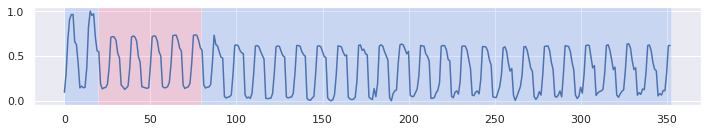

In [ ]:
algo = rpt.Binseg(model="l2").fit(y_tmp.values)
result = algo.predict(n_bkps=2)
print(result)

rpt.display(y_tmp, result)

[90, 235, 330, 335, 353]


(<Figure size 720x144 with 1 Axes>,
 [<matplotlib.axes._subplots.AxesSubplot at 0x7f00c6774590>])

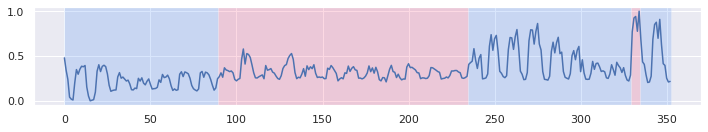

In [ ]:
algo = rpt.Binseg(model="l2").fit(y_hum.values)
result = algo.predict(n_bkps=4)
print(result)

rpt.display(y_hum, result)